In [51]:
import os
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import pearsonr
from flexitext import flexitext
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans


- Maybe sub-group affect data does forecast, but not neuro data. 
- Add total to aggregate heatmap.


# Homemade functions

In [52]:
def get_trailer_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id-1:peak_id])
    else:
        peak = np.mean(timecourse[peak_id-1:peak_id+1])
    
    return peak, peak_id

# Clean data

In [53]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/GitHub", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/la/Documents/GitHub


In [54]:
# Open csv file. 
all_subs_events_df = pd.read_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation.csv') #AllSubs_NeuralActivation_main
all_subs_ISC_df = pd.read_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralISC.csv')
all_subs_GLM_df = pd.read_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_GLM.csv')

# Get data from ISC analysis.
ISC_cols = ['NAcc_ISC', 'AIns_ISC', 'MPFC_ISC', "NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC",
            "NAcc_DH_ISC", "AIns_DH_ISC", "MPFC_DH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",
            "NAcc_DC_ISC", "AIns_DC_ISC", "MPFC_DC_ISC", 'NAcc_MPFC', 'AIns_MPFC', 'NAcc_AIns', 'NAcc_MPFC_ISFC', 
            'AIns_MPFC_ISFC', 'NAcc_AIns_ISFC', 'AIns_NAcc_ISFC', 'MPFC_NAcc_ISFC', 'MPFC_AIns_ISFC']
all_subs_ISC_df = all_subs_ISC_df[ISC_cols] 

# Get data from GLM analysis.
GLM_cols = ["NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", "NAcc_GLM_seg1", "AIns_GLM_seg1", "vmPFC_GLM_seg1",
            "NAcc_GLM_seg2", "AIns_GLM_seg2", "vmPFC_GLM_seg2", "NAcc_GLM_seg3", "AIns_GLM_seg3", "vmPFC_GLM_seg3",
            "NAcc_GLM_seg4", "AIns_GLM_seg4", "vmPFC_GLM_seg4", "NAcc_GLM_seg5", "AIns_GLM_seg5", "vmPFC_GLM_seg5",
            "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
            "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
            "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",]
all_subs_GLM_df = all_subs_GLM_df[GLM_cols] 

# Concatenate the dataframes.
all_subs_events_df = pd.concat([all_subs_events_df, all_subs_ISC_df], axis=1)
all_subs_events_df = pd.concat([all_subs_events_df, all_subs_GLM_df], axis=1)

# Save the dataframe.
all_subs_events_df.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuroTS_GLM_ISC.csv', index=False)

print("The un-cleaned shape of the dataframe is: ", all_subs_events_df.shape)
all_subs_events_df.head()


The un-cleaned shape of the dataframe is:  (1024, 347)


Participant Trailer    Type  W_score  A_score  F_score  NAcc_onset  \
0      sub-01     rh6  Horror      3.0      3.0      2.0    0.396752   
1      sub-01     uh1  Horror      1.0      3.0      3.0    0.098696   
2      sub-01     rc2  Comedy      1.0      1.0      3.0   -1.063516   
3      sub-01     rh2  Horror      3.0      2.0      2.0    0.637617   
4      sub-01     rh1  Horror      4.0      3.0      2.0   -0.452684   

   AIns_onset  MPFC_onset  NAcc_middle  ...  Sim_Speer_seg1  Sim_Kragel_seg1  \
0    0.657827    0.759440    -0.666929  ...        0.006340         0.041484   
1    0.295622    0.136385    -0.098751  ...        0.043913         0.012102   
2   -1.059873   -0.015051     0.222832  ...       -0.037096         0.025625   
3   -0.650366   -0.676718     0.005747  ...       -0.039930        -0.018348   
4    0.155205   -0.119316     0.034977  ...       -0.006552         0.036352   

   Sim_Zhou_seg1  Sim_Ceko_GNAS1_seg1  Sim_Ceko_GNAS2_seg1  Sim_Speer_seg5  \
0       0.029547            -0.025011            -0.025846       -0.066598   
1       0.017056            -0.013382            -0.029733       -0.070944   
2       0.015643             0.002686             0.016118       -0.064964   
3      -0.016697            -0.002956            -0.005773       -0.043432   
4      -0.033895            -0.007844             0.008693        0.011330   

   Sim_Kragel_seg5  Sim_Zhou_seg5  Sim_Ceko_GNAS1_seg5  Sim_Ceko_GNAS2_seg5  
0        -0.001268      -0.040712             0.031819             0.037773  
1         0.013172      -0.010922             0.026703             0.020526  
2        -0.003612       0.052806             0.024070             0.036442  
3        -0.017301       0.022471             0.016936             0.014827  
4         0.011759      -0.014826             0.015716             0.030278  

[5 rows x 347 columns]

In [55]:
# Getting Horror and Comedy Like-Dislike subgroups.

# Sepatare the dataframe into Horror and Comedy trials.
all_subs_events_horror = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]
all_subs_events_horror.reset_index(drop=True, inplace=True)

all_subs_events_comedy = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]
all_subs_events_comedy.reset_index(drop=True, inplace=True)

# Get the mean and std of the W_score_scaled for each participant.
numeric_cols = all_subs_events_comedy.select_dtypes(include=['number']).columns

Individuals_mean_comedy_df = all_subs_events_comedy.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
Individuals_std_comedy_df = all_subs_events_comedy.groupby("Participant", as_index=False, dropna=False)[numeric_cols].std()
Individuals_mean_comedy_df["W_score_scaled_std"] = Individuals_std_comedy_df["W_score_scaled"]
Individuals_mean_comedy_df["Type"] = "Comedy"

Individuals_mean_horror_df = all_subs_events_horror.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
Individuals_std_horror_df = all_subs_events_horror.groupby("Participant", as_index=False, dropna=False)[numeric_cols].std()
Individuals_mean_horror_df["W_score_scaled_std"] = Individuals_std_horror_df["W_score_scaled"]
Individuals_mean_horror_df["Type"] = "Horror"

In [56]:



# Use k-mean clustering to separate participants into subgroups: those who like and dislike horror and comedy movies.
kmeans_horror = KMeans(n_clusters = 2, random_state = 2)
kmeans_comedy = KMeans(n_clusters = 2, random_state = 2)

Individuals_mean_horror_array = np.array(Individuals_mean_horror_df["W_score_scaled"]).reshape(-1, 1)
Individuals_mean_comedy_array = np.array(Individuals_mean_comedy_df["W_score_scaled"]).reshape(-1, 1)

kmeans_horror.fit(Individuals_mean_horror_array)
kmeans_comedy.fit(Individuals_mean_comedy_array)

if(kmeans_horror.cluster_centers_[0] == kmeans_horror.cluster_centers_.max()):
    horror_cluster_label_LH = 0
    horror_cluster_label_DH = 1
else:
    horror_cluster_label_LH = 1
    horror_cluster_label_DH = 0

if(kmeans_comedy.cluster_centers_[0] == kmeans_comedy.cluster_centers_.max()):
    comedy_cluster_label_LC = 0
    comedy_cluster_label_DC = 1
else:
    comedy_cluster_label_LC = 1
    comedy_cluster_label_DC = 0

Individuals_mean_horror_df["LH_cluster_prefrence"] = kmeans_horror.labels_
Individuals_mean_comedy_df["LC_cluster_prefrence"] = kmeans_comedy.labels_

# Get the list of participants who like and dislike horror and comedy movies.
# Dislike_horror_list = []
# Like_horror_list = []

# Dislike_comedy_list = []
# Like_comedy_list = []

# participants_list = all_subs_events_df["Participant"].unique()

# for participant_id in range(len(participants_list)):

#     if Individuals_mean_horror_df.loc[participant_id, "W_score_scaled"] < horror_cluster_label_DH: #0:
#         Dislike_horror_list.append(participants_list[participant_id])
#     else: 
#         Like_horror_list.append(participants_list[participant_id])

#     if Individuals_mean_comedy_df.loc[participant_id, "W_score_scaled"] < comedy_cluster_label_DC: #0:
#         Dislike_comedy_list.append(participants_list[participant_id])
#     else:
#         Like_comedy_list.append(participants_list[participant_id])

# print("Participants who dislike horror movies: ", Dislike_horror_list)
# print("Participants who like horror movies: ", Like_horror_list)

# print("\nParticipants who dislike comedy movies: ", Dislike_comedy_list)
# print("Participants who like comedy movies: ", Like_comedy_list)

#print("The threshold for the watch score for horror movies is: ", Horror_w_threshold)



In [57]:
type(Individuals_mean_horror_df.loc[(Individuals_mean_horror_df["Participant"] == "sub-01")]["LH_cluster_prefrence"].values[0])



numpy.int32

In [58]:
Dislike_horror_list = []
Like_horror_list = []

Dislike_comedy_list = []
Like_comedy_list = []

participants_list = all_subs_events_df["Participant"].unique()

participants_list = participants_list[:-1]

# Declare new col and set values to zero.

for participant_id in participants_list:

    # Get current participant's cluster preference.
    current_sub_horror_cluster_pref  = int(Individuals_mean_horror_df.loc[(Individuals_mean_horror_df["Participant"] == participant_id)]["LH_cluster_prefrence"].values)
    current_sub_comedy_cluster_pref  = int(Individuals_mean_comedy_df.loc[(Individuals_mean_comedy_df["Participant"] == participant_id), "LC_cluster_prefrence"].values)

    if (current_sub_horror_cluster_pref == horror_cluster_label_DH): #0:
        Dislike_horror_list.append(participant_id)
    else: 
        Like_horror_list.append(participant_id)

    if  (current_sub_comedy_cluster_pref== comedy_cluster_label_DC): #0:
        Dislike_comedy_list.append(participant_id)
    else:
        Like_comedy_list.append(participant_id)

print("Participants who dislike horror movies: ", Dislike_horror_list)
print("Participants who like horror movies: ", Like_horror_list)

print("\nParticipants who dislike comedy movies: ", Dislike_comedy_list)
print("Participants who like comedy movies: ", Like_comedy_list)

# # Add the preference column to the dataframes.
all_subs_events_df["H_preference"] = "Like"
all_subs_events_df["C_preference"] = "Like"

for participant_id in range(len(participants_list)):

    if participants_list[participant_id] in Dislike_horror_list:
        all_subs_events_df.loc[all_subs_events_df["Participant"] == participants_list[participant_id], "H_preference"] = "Dislike"

    if participants_list[participant_id] in Dislike_comedy_list:
        all_subs_events_df.loc[all_subs_events_df["Participant"] == participants_list[participant_id], "C_preference"] = "Dislike"


Participants who dislike horror movies:  ['sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-18', 'sub-21', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']
Participants who like horror movies:  ['sub-01', 'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']

Participants who dislike comedy movies:  ['sub-01', 'sub-08', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']
Participants who like comedy movies:  ['sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-10', 'sub-18', 'sub-21', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']


In [59]:
# # Separate files based on type of trailer. 
all_subs_events_df.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC.csv')

all_subs_events_horror = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]
all_subs_events_horror.reset_index(drop=True, inplace=True)
all_subs_events_horror.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC_Horror.csv')

all_subs_events_comedy = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]
all_subs_events_comedy.reset_index(drop=True, inplace=True)
all_subs_events_comedy.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC_Comedy.csv')


# Visualize data 

## Behavioral Associations. 

In [60]:
# Correlation between W_score and Pos_arousal and A_score and Pos_arousal for both types of trailers. 

# W_PA_All_corr = pearsonr(all_subs_events_df["W_score_scaled"], all_subs_events_df["Pos_arousal_scaled"])
# W_NA_All_corr = pearsonr(all_subs_events_df["W_score_scaled"], all_subs_events_df["Neg_arousal_scaled"])

# print("The correlation between W_score and Pos_arousal is: " + str(round(W_PA_All_corr[0], 4)) + " with a p-value of: " + str((W_PA_All_corr[1])))
# print("The correlation between W_score and Neg_arousal is: " + str(round(W_NA_All_corr[0], 4)) + " with a p-value of: " + str((W_NA_All_corr[1])))

# fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# # Plot the correlation between W_score and Pos_arousal.
# W_PA_plot = sns.regplot(data=all_subs_events_df, x="Pos_arousal_scaled", y="W_score_scaled", ax=axs[0])
# W_PA_plot.set_title("Correlation between W_score and Pos_arousal")
# W_PA_plot.set_xlabel("Positive arousal")
# W_PA_plot.set_ylabel("Watch score")

# # Plot the correlation between W_score and Neg_arousal.
# W_NA_plot = sns.regplot(data=all_subs_events_df, x="Neg_arousal_scaled", y="W_score_scaled", ax=axs[1])
# W_NA_plot.set_title("Correlation between W_score and Neg_arousal")
# W_NA_plot.set_xlabel("Negative arousal")
# W_NA_plot.set_ylabel("Watch score")

# # Add annotation to the plot. 
# W_PA_string = "r= " + str(round(W_PA_All_corr[0], 4)) + "; p-value: " + str((W_PA_All_corr[1]))
# axs[0].text(s=W_PA_string, x=-1, y=-2, fontsize=10)
# W_NA_string = "r= " + str(round(W_NA_All_corr[0], 4)) + "; p-value: " + str((W_NA_All_corr[1]))
# axs[1].text(s=W_NA_string, x=-1, y=-2, fontsize=10)


In [61]:
# # Correlation between W_score and Pos_arousal and A_score and Pos_arousal for comedy trailers.
# W_PA_comedy_corr = pearsonr(all_subs_events_comedy["W_score_scaled"], all_subs_events_comedy["Pos_arousal_scaled"])
# W_NA_comedy_corr = pearsonr(all_subs_events_comedy["W_score_scaled"], all_subs_events_comedy["Neg_arousal_scaled"])

# print("The correlation between W_score and Pos_arousal for comedy trailers is: " + str(round(W_PA_comedy_corr[0], 4)) + " with a p-value of: " + str((W_PA_comedy_corr[1])))
# print("The correlation between W_score and Neg_arousal for comedy trailers is: " + str(round(W_NA_comedy_corr[0], 4)) + " with a p-value of: " + str((W_NA_comedy_corr[1])))

# # Correlation between W_score and Pos_arousal and A_score and Pos_arousal for horror trailers.
# W_PA_horror_corr = pearsonr(all_subs_events_horror["W_score_scaled"], all_subs_events_horror["Pos_arousal_scaled"])
# W_NA_horror_corr = pearsonr(all_subs_events_horror["W_score_scaled"], all_subs_events_horror["Neg_arousal_scaled"])

# print("\nThe correlation between W_score and Pos_arousal for horror trailers is: " + str(round(W_PA_horror_corr[0], 4)) + " with a p-value of: " + str((W_PA_horror_corr[1])))
# print("The correlation between W_score and Neg_arousal for horror trailers is: " + str(round(W_NA_horror_corr[0], 4)) + " with a p-value of: " + str((W_NA_horror_corr[1])))


In [62]:

#all_participants_cleaned_df = pd.read_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC.csv')


#all_participants_cleaned_df["Watch_choice"] = np.where(all_participants_cleaned_df["W_score"] < 3, "No", "Yes")

# W_PA_NA_bothTrailers_behavioral_plot = sns.pairplot(
#      all_participants_cleaned_df,
#      kind="reg",
#      x_vars=["Pos_arousal_scaled", "Neg_arousal_scaled"],
#      y_vars=["W_score_scaled"], 
#      palette="crest",
#      hue="Type",
#      height=4,
#      aspect=1.7)

# W_comedy_PA_string = "C r= " + str(round(W_PA_comedy_corr[0], 4)) + "; p-value: " + str((W_PA_comedy_corr[1]))
# W_horror_PA_string = "H r= " + str(round(W_PA_horror_corr[0], 4)) + "; p-value: " + str((W_PA_horror_corr[1]))
# W_PA_NA_bothTrailers_behavioral_plot.axes[0, 0].text(s=W_comedy_PA_string, x=-.8, y=-2, fontsize=10)
# W_PA_NA_bothTrailers_behavioral_plot.axes[0, 0].text(s=W_horror_PA_string, x=-.8, y=-2.5, fontsize=10)

# W_comedy_NA_string = "C r= " + str(round(W_PA_comedy_corr[0], 4)) + "; p-value: " + str((W_PA_comedy_corr[1]))
# W_horror_NA_string = "H r= " + str(round(W_PA_horror_corr[0], 4)) + "; p-value: " + str((W_PA_horror_corr[1]))
# W_PA_NA_bothTrailers_behavioral_plot.axes[0, 1].text(s=W_comedy_NA_string, x=-.8, y=-2, fontsize=10)
# W_PA_NA_bothTrailers_behavioral_plot.axes[0, 1].text(s=W_horror_NA_string, x=-.8, y=-2.5, fontsize=10)

Text(0.5, 1.0, 'Standard deviation of watch score for each participant')

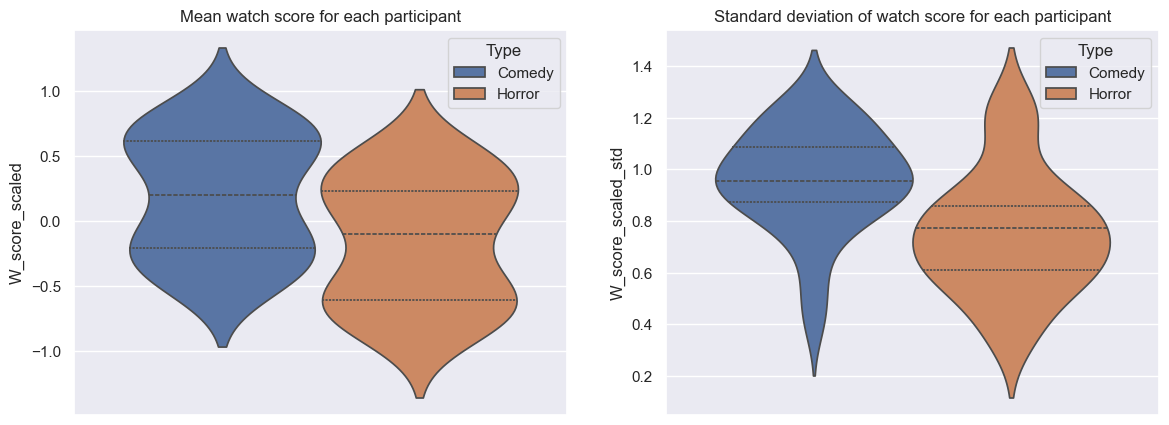

In [63]:
# Catching participants who consistently disliked horror/comedy movies. 
Individuals_mean_comedy_df = all_subs_events_comedy.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
Individuals_std_comedy_df = all_subs_events_comedy.groupby("Participant", as_index=False, dropna=False)[numeric_cols].std()
Individuals_mean_comedy_df["W_score_scaled_std"] = Individuals_std_comedy_df["W_score_scaled"]
Individuals_mean_comedy_df["Type"] = "Comedy"

Individuals_mean_horror_df = all_subs_events_horror.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
Individuals_std_horror_df = all_subs_events_horror.groupby("Participant", as_index=False, dropna=False)[numeric_cols].std()
Individuals_mean_horror_df["W_score_scaled_std"] = Individuals_std_horror_df["W_score_scaled"]
Individuals_mean_horror_df["Type"] = "Horror"

all_participants_means_df = pd.concat([Individuals_mean_comedy_df, Individuals_mean_horror_df], ignore_index=True)

sns.set(font_scale=1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.violinplot(data=all_participants_means_df, y="W_score_scaled", hue="Type", inner="quart", ax=axs[0])
axs[0].set_title("Mean watch score for each participant")

sns.violinplot(data=all_participants_means_df, y="W_score_scaled_std", hue="Type", inner="quart", ax=axs[1])
axs[1].set_title("Standard deviation of watch score for each participant")



In [64]:
# # Get threshold for participants to exclude because the just don't like horror movies. 
# Horror_w_threshold = Individuals_mean_horror_df["W_score_scaled"].describe()["50%"]
# Comedy_w_threshold = Individuals_mean_comedy_df["W_score_scaled"].describe()["50%"]

# #print("The threshold for the watch score for horror movies is: ", Horror_w_threshold)

# Dislike_horror_list = []
# Like_horror_list = []

# Dislike_comedy_list = []
# Like_comedy_list = []

# for participant_id in range(len(participants_list)):

#     if Individuals_mean_horror_df.loc[participant_id, "W_score_scaled"] < Horror_w_threshold: #0:
#         Dislike_horror_list.append(participants_list[participant_id])
#     else: 
#         Like_horror_list.append(participants_list[participant_id])

#     if Individuals_mean_comedy_df.loc[participant_id, "W_score_scaled"] < Comedy_w_threshold: #0:
#         Dislike_comedy_list.append(participants_list[participant_id])
#     else:
#         Like_comedy_list.append(participants_list[participant_id])

# print("Participants who dislike horror movies: ", Dislike_horror_list)
# print("Participants who like horror movies: ", Like_horror_list)

# print("\nParticipants who dislike comedy movies: ", Dislike_comedy_list)
# print("Participants who like comedy movies: ", Like_comedy_list)


In [65]:
# # Create separate dataframes for participants that like and dislike horror movies. 
# Like_horror_df = pd.DataFrame()
# Dislike_horror_df = pd.DataFrame()

# for participant_id in range(len(participants_list)):

#     if participants_list[participant_id] in Like_horror_list:
#         Like_horror_df = pd.concat([Like_horror_df, all_subs_events_horror[all_subs_events_horror["Participant"] == participants_list[participant_id]]], ignore_index=True)

#     if participants_list[participant_id] in Dislike_horror_list:
#         Dislike_horror_df = pd.concat([Dislike_horror_df, all_subs_events_horror[all_subs_events_horror["Participant"] == participants_list[participant_id]]], ignore_index=True)

# # Add column to main dataframe to distinguish participants that like and dislike horror movies. 
# #all_subs_events_df["H_preference"] = "Like"
# all_participants_means_df["H_preference"] = "Like"

# #all_subs_events_df["C_preference"] = "Like"
# all_participants_means_df["C_preference"] = "Like"

# for participant_id in range(len(participants_list)):

#     if participants_list[participant_id] in Dislike_horror_list:
#         #all_subs_events_df.loc[all_subs_events_df["Participant"] == participants_list[participant_id], "H_preference"] = "Dislike"
#         all_participants_means_df.loc[all_participants_means_df["Participant"] == participants_list[participant_id], "H_preference"] = "Dislike"

#     if participants_list[participant_id] in Dislike_comedy_list:
#         #all_subs_events_df.loc[all_subs_events_df["Participant"] == participants_list[participant_id], "C_preference"] = "Dislike"
#         all_participants_means_df.loc[all_participants_means_df["Participant"] == participants_list[participant_id], "C_preference"] = "Dislike"



In [66]:
# # Create separate dataframes for participants that like and dislike horror movies. 
# Like_horror_df = pd.DataFrame()
# Dislike_horror_df = pd.DataFrame()

# for participant_id in range(len(participants_list)):

#     if participants_list[participant_id] in Like_horror_list:
#         Like_horror_df = pd.concat([Like_horror_df, all_subs_events_horror[all_subs_events_horror["Participant"] == participants_list[participant_id]]], ignore_index=True)

#     if participants_list[participant_id] in Dislike_horror_list:
#         Dislike_horror_df = pd.concat([Dislike_horror_df, all_subs_events_horror[all_subs_events_horror["Participant"] == participants_list[participant_id]]], ignore_index=True)

# # Add column to main dataframe to distinguish participants that like and dislike horror movies. 
# #all_subs_events_df["H_preference"] = "Like"
all_participants_means_df["H_preference"] = "Like"

# #all_subs_events_df["C_preference"] = "Like"
all_participants_means_df["C_preference"] = "Like"

for participant_id in range(len(participants_list)):

    if participants_list[participant_id] in Dislike_horror_list:
#         #all_subs_events_df.loc[all_subs_events_df["Participant"] == participants_list[participant_id], "H_preference"] = "Dislike"
        all_participants_means_df.loc[all_participants_means_df["Participant"] == participants_list[participant_id], "H_preference"] = "Dislike"

    if participants_list[participant_id] in Dislike_comedy_list:
#         #all_subs_events_df.loc[all_subs_events_df["Participant"] == participants_list[participant_id], "C_preference"] = "Dislike"
        all_participants_means_df.loc[all_participants_means_df["Participant"] == participants_list[participant_id], "C_preference"] = "Dislike"



/var/folders/6h/j6h8_h1d0sx06cyf77m5wmg40000gn/T/ipykernel_7467/2937040998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_subs_events_df, y="Pos_arousal_scaled", x="Type", palette="viridis", ax=axs[0])
/var/folders/6h/j6h8_h1d0sx06cyf77m5wmg40000gn/T/ipykernel_7467/2937040998.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_subs_events_df, y="Neg_arousal_scaled", x="Type", palette="viridis", ax=axs[1])
/var/folders/6h/j6h8_h1d0sx06cyf77m5wmg40000gn/T/ipykernel_7467/2937040998.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  

<Axes: xlabel='Type', ylabel='W_score_scaled'>

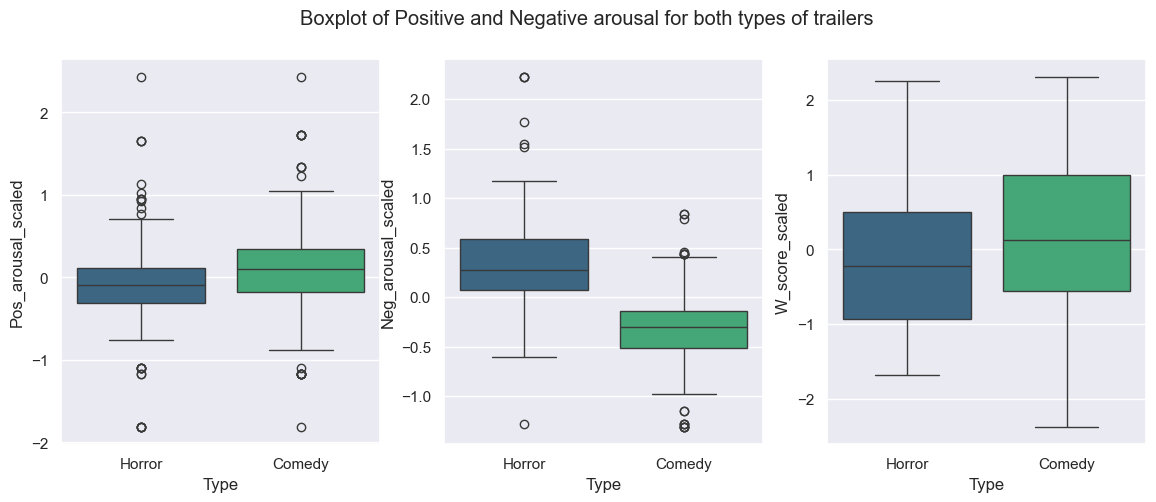

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharex=True)
fig.suptitle("Boxplot of Positive and Negative arousal for both types of trailers")
sns.boxplot(data=all_subs_events_df, y="Pos_arousal_scaled", x="Type", palette="viridis", ax=axs[0])
sns.boxplot(data=all_subs_events_df, y="Neg_arousal_scaled", x="Type", palette="viridis", ax=axs[1])
sns.boxplot(data=all_subs_events_df, y="W_score_scaled", x="Type", palette="viridis", ax=axs[2])


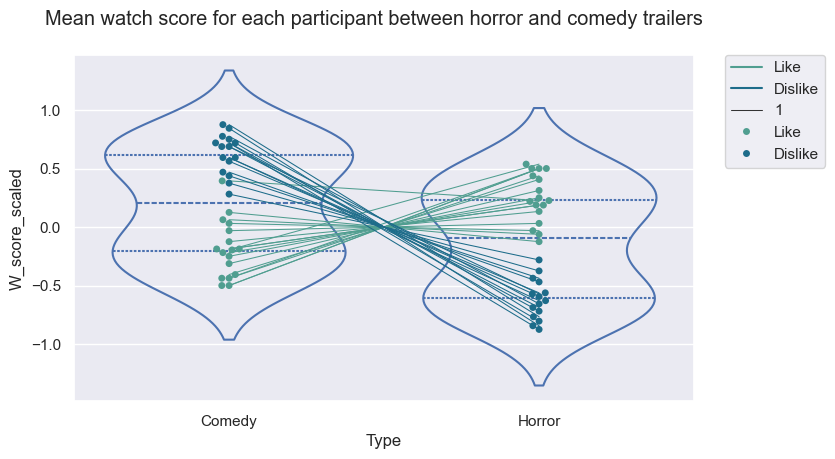

In [68]:
fig, axs = plt.subplots(figsize=(8, 4.5), sharex=True)

sns.violinplot(data=all_participants_means_df, y="W_score_scaled", x="Type", inner="quart", fill=False, palette=None, ax=axs)

sns.lineplot(data=all_participants_means_df, y="W_score_scaled", x="Type", hue="H_preference",
                 estimator=None, 
                 units="Participant",  
                 markers=True, 
                 size=1,
                 palette="crest",
                 ax=axs)

sns.swarmplot(data=all_participants_means_df, y="W_score_scaled", x="Type", hue="H_preference", palette="crest", 
              dodge=False, ax=axs) 

fig.suptitle("Mean watch score for each participant between horror and comedy trailers")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #labels=["Like", "Dislike"], ,  

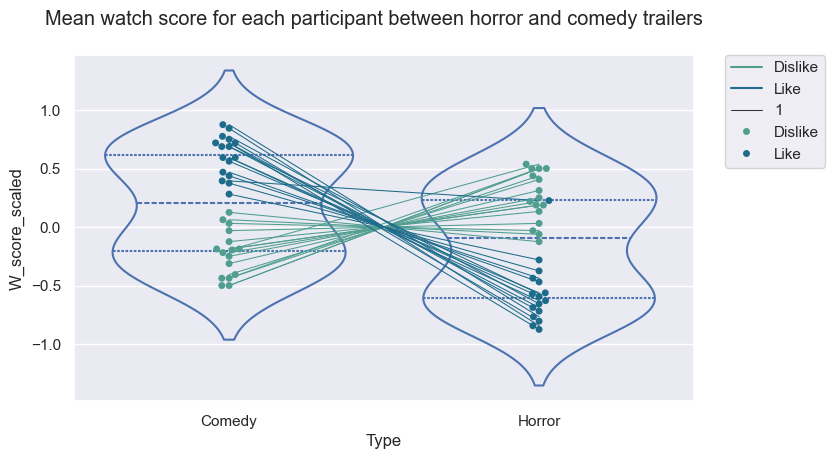

In [69]:
fig, axs = plt.subplots(figsize=(8, 4.5), sharex=True)

sns.violinplot(data=all_participants_means_df, y="W_score_scaled", x="Type", inner="quart", fill=False, palette=None, ax=axs)

sns.lineplot(data=all_participants_means_df, y="W_score_scaled", x="Type", hue="C_preference",
                 estimator=None, 
                 units="Participant",  
                 markers=True, 
                 size=1,
                 palette="crest",
                 ax=axs)

sns.swarmplot(data=all_participants_means_df, y="W_score_scaled", x="Type", hue="C_preference", palette="crest", 
              dodge=False, ax=axs) 

fig.suptitle("Mean watch score for each participant between horror and comedy trailers")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


The correlation between W_score and Pos_arousal for Like horror group is: 0.4919 with a p-value of: 1.2944592396077564e-17
The correlation between W_score and Neg_arousal for Like horror group is: 0.0685 with a p-value of: 0.26528793988364685

The correlation between W_score and Pos_arousal for Dislike horror group is: 0.3933 with a p-value of: 4.4470595148460035e-10
The correlation between W_score and Neg_arousal for Dislike horror group is: -0.3382 with a p-value of: 1.1416032114968528e-07


Text(-0.5, 1.2, 'DH r= -0.3382; p-value: 1.1416032114968528e-07')

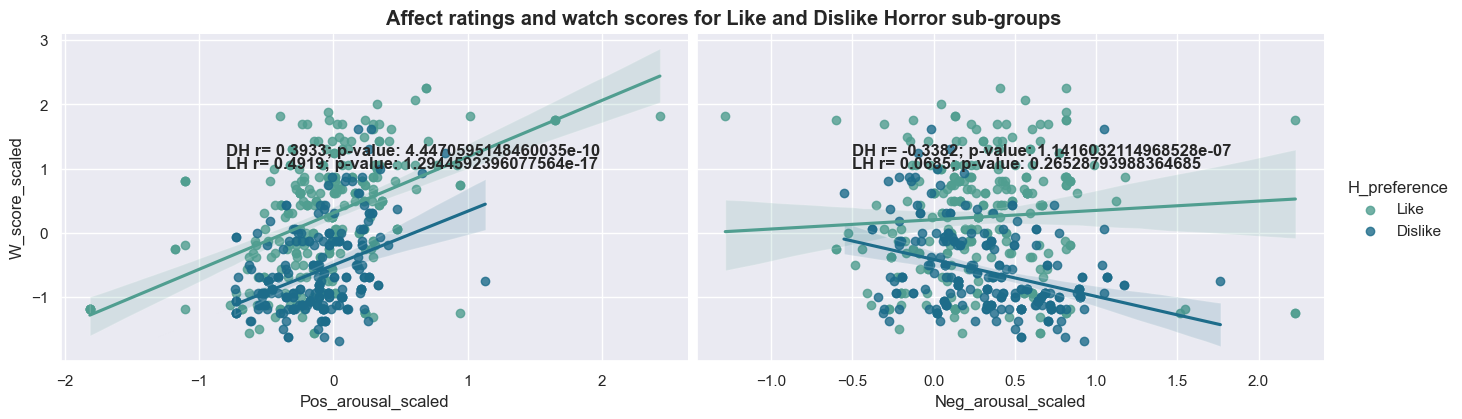

In [70]:
all_subs_events_horror = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]
all_subs_events_horror.reset_index(drop=True, inplace=True)

# Correlation between W_score and Pos_arousal and A_score and Pos_arousal for Like horror group.
W_PA_LH_corr = pearsonr(all_subs_events_horror[all_subs_events_horror["H_preference"] == "Like"]["W_score_scaled"], all_subs_events_horror[all_subs_events_horror["H_preference"] == "Like"]["Pos_arousal_scaled"])
W_NA_LH_corr = pearsonr(all_subs_events_horror[all_subs_events_horror["H_preference"] == "Like"]["W_score_scaled"], all_subs_events_horror[all_subs_events_horror["H_preference"] == "Like"]["Neg_arousal_scaled"])

print("The correlation between W_score and Pos_arousal for Like horror group is: " + str(round(W_PA_LH_corr[0], 4)) + " with a p-value of: " + str((W_PA_LH_corr[1])))
print("The correlation between W_score and Neg_arousal for Like horror group is: " + str(round(W_NA_LH_corr[0], 4)) + " with a p-value of: " + str((W_NA_LH_corr[1])))

# Correlation between W_score and Pos_arousal and A_score and Pos_arousal for Dislike horror group.
W_PA_DH_corr = pearsonr(all_subs_events_horror[all_subs_events_horror["H_preference"] == "Dislike"]["W_score_scaled"], all_subs_events_horror[all_subs_events_horror["H_preference"] == "Dislike"]["Pos_arousal_scaled"])
W_NA_DH_corr = pearsonr(all_subs_events_horror[all_subs_events_horror["H_preference"] == "Dislike"]["W_score_scaled"], all_subs_events_horror[all_subs_events_horror["H_preference"] == "Dislike"]["Neg_arousal_scaled"])

print("\nThe correlation between W_score and Pos_arousal for Dislike horror group is: " + str(round(W_PA_DH_corr[0], 4)) + " with a p-value of: " + str((W_PA_DH_corr[1])))
print("The correlation between W_score and Neg_arousal for Dislike horror group is: " + str(round(W_NA_DH_corr[0], 4)) + " with a p-value of: " + str((W_NA_DH_corr[1])))

W_PA_NA_HorrorTrailers_plot = sns.pairplot(
     all_subs_events_horror,
     kind="reg",
     x_vars=["Pos_arousal_scaled", "Neg_arousal_scaled"],
     y_vars=["W_score_scaled"], 
     palette="crest",
     hue="H_preference",
     height=4,
     aspect=1.7)
W_PA_NA_HorrorTrailers_plot.fig.suptitle("Affect ratings and watch scores for Like and Dislike Horror sub-groups", va="top", fontweight='bold', y=1.03)

W_LH_PA_string = "LH r= " + str(round(W_PA_LH_corr[0], 4)) + "; p-value: " + str((W_PA_LH_corr[1]))
W_DH_PA_string = "DH r= " + str(round(W_PA_DH_corr[0], 4)) + "; p-value: " + str((W_PA_DH_corr[1]))
W_PA_NA_HorrorTrailers_plot.axes[0, 0].text(s=W_LH_PA_string, x=-.8, y=1, fontsize=12, weight='bold')
W_PA_NA_HorrorTrailers_plot.axes[0, 0].text(s=W_DH_PA_string, x=-.8, y=1.2, fontsize=12, weight='bold')

W_LH_NA_string = "LH r= " + str(round(W_NA_LH_corr[0], 4)) + "; p-value: " + str((W_NA_LH_corr[1]))
W_DH_NA_string = "DH r= " + str(round(W_NA_DH_corr[0], 4)) + "; p-value: " + str((W_NA_DH_corr[1]))
W_PA_NA_HorrorTrailers_plot.axes[0, 1].text(s=W_LH_NA_string, x=-.5, y=1, fontsize=12, weight='bold')
W_PA_NA_HorrorTrailers_plot.axes[0, 1].text(s=W_DH_NA_string, x=-.5, y=1.2, fontsize=12, weight='bold')


In [71]:
# all_subs_events_comedy = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]
# all_subs_events_comedy.reset_index(drop=True, inplace=True)

# # Correlation between W_score and Pos_arousal and A_score and Pos_arousal for Like comedy group.
# W_PA_LC_corr = pearsonr(all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Like"]["W_score_scaled"], all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Like"]["Pos_arousal_scaled"])
# W_NA_LC_corr = pearsonr(all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Like"]["W_score_scaled"], all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Like"]["Neg_arousal_scaled"])

# print("The correlation between W_score and Pos_arousal for Like comedy group is: " + str(round(W_PA_LC_corr[0], 4)) + " with a p-value of: " + str((W_PA_LC_corr[1])))
# print("The correlation between W_score and Neg_arousal for Like comedy group is: " + str(round(W_NA_LC_corr[0], 4)) + " with a p-value of: " + str((W_NA_LC_corr[1])))
      
# # Correlation between W_score and Pos_arousal and A_score and Pos_arousal for Dislike comedy group.
# W_PA_DC_corr = pearsonr(all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Dislike"]["W_score_scaled"], all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Dislike"]["Pos_arousal_scaled"])
# W_NA_DC_corr = pearsonr(all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Dislike"]["W_score_scaled"], all_subs_events_comedy[all_subs_events_comedy["C_preference"] == "Dislike"]["Neg_arousal_scaled"])

# print("\nThe correlation between W_score and Pos_arousal for Dislike comedy group is: " + str(round(W_PA_DC_corr[0], 4)) + " with a p-value of: " + str((W_PA_DC_corr[1])))
# print("The correlation between W_score and Neg_arousal for Dislike comedy group is: " + str(round(W_NA_DC_corr[0], 4)) + " with a p-value of: " + str((W_NA_DC_corr[1])))

# W_PA_NA_ComedyTrailers_plot = sns.pairplot(
#      all_subs_events_comedy,
#      kind="reg",
#      x_vars=["Pos_arousal_scaled", "Neg_arousal_scaled"],
#      y_vars=["W_score_scaled"], 
#      palette="crest",
#      hue="C_preference",
#      height=4,
#      aspect=1.7)
# W_PA_NA_ComedyTrailers_plot.fig.suptitle("Affect ratings and watch scores for Like and Dislike Comedy sub-groups.", va="top", fontweight='bold', y=1.03)

# W_LC_PA_string = "LC r= " + str(round(W_PA_LC_corr[0], 4)) + "; p-value: " + str((W_PA_LC_corr[1]))
# W_DC_PA_string = "DC r= " + str(round(W_PA_DC_corr[0], 4)) + "; p-value: " + str((W_PA_DC_corr[1]))

# W_PA_NA_ComedyTrailers_plot.axes[0, 0].text(s=W_LC_PA_string, x=-.8, y=2, fontsize=12, weight='bold')
# W_PA_NA_ComedyTrailers_plot.axes[0, 0].text(s=W_DC_PA_string, x=-.8, y=2.3, fontsize=12, weight='bold')

# W_LC_NA_string = "LC r= " + str(round(W_NA_LC_corr[0], 4)) + "; p-value: " + str((W_NA_LC_corr[1]))
# W_DC_NA_string = "DC r= " + str(round(W_NA_DC_corr[0], 4)) + "; p-value: " + str((W_NA_DC_corr[1]))

# W_PA_NA_ComedyTrailers_plot.axes[0, 1].text(s=W_LC_NA_string, x=-.5, y=2, fontsize=12, weight='bold')
# W_PA_NA_ComedyTrailers_plot.axes[0, 1].text(s=W_DC_NA_string, x=-.5, y=2.3, fontsize=12, weight='bold')

In [72]:
all_subs_events_df["F_score_scaled"] = 0

for sub_id in participants_list: 

    # Calculate mean feel score for current subject. 
    current_sub_mean_f = all_subs_events_df[all_subs_events_df["Participant"] == sub_id]["F_score"].mean()

    # Calculate std feel score for current subject. 
    current_sub_std_f = all_subs_events_df[all_subs_events_df["Participant"] == sub_id]["F_score"].std()

    # Mean center F score for current participant.
    all_subs_events_df.loc[all_subs_events_df["Participant"] == sub_id, "F_score_scaled"] = (all_subs_events_df[all_subs_events_df["Participant"] == sub_id]["F_score"] - current_sub_mean_f)/current_sub_std_f


/var/folders/6h/j6h8_h1d0sx06cyf77m5wmg40000gn/T/ipykernel_7467/2861644535.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.41046103  0.41046103  0.41046103 -0.41046103 -0.41046103  1.2313831
  1.2313831  -0.41046103 -1.2313831   0.41046103 -0.41046103  0.41046103
  0.41046103 -1.2313831   1.2313831   1.2313831   1.2313831  -1.2313831
  0.41046103 -1.2313831   1.2313831   0.41046103 -1.2313831   1.2313831
 -1.2313831   0.41046103 -1.2313831  -1.2313831   1.2313831  -1.2313831
  1.2313831  -1.2313831 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_subs_events_df.loc[all_subs_events_df["Participant"] == sub_id, "F_score_scaled"] = (all_subs_events_df[all_subs_events_df["Participant"] == sub_id]["F_score"] - current_sub_mean_f)/current_sub_std_f


In [73]:
all_participants_means_df.columns[50]

'AIns_seg3_z'

In [74]:
# Plot..
# sub_group_means_horror = all_participants_means_df.groupby(['H_preference']).mean()
# sub_group_means_comedy = all_participants_means_df.groupby(['C_preference']).mean()

# sub_group_means_horror["kind"] = ["Dislike_H", "Like_H"]
# sub_group_means_comedy["kind"] = ["Dislike_C", "Like_C"]

# # concat 
# sub_group_means = pd.concat([sub_group_means_horror, sub_group_means_comedy], axis=0)

# sns.scatterplot(sub_group_means, x="Neg_arousal_scaled", y="Pos_arousal_scaled", hue="kind")




## Neural Activation Whole Average 

In [75]:
#test_title = "Correlations for whole activation for both types of trailers"
#compute_and_plot_corrs(all_participants_cleaned_df, "whole", test_title)

In [76]:

#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "whole", "Correlations for whole activation for both types of trailers")


## Neural Activation Offset 

In [77]:
#offset_title = "Correlations for offset activation for both types of trailers"
#compute_and_plot_corrs(all_participants_cleaned_df, "offset", offset_title)

In [78]:
#offset_title = 'Offset time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "offset", offset_title)


# Neural activation middle

In [79]:
#middle_title = "Correlations for middle activation for both types of trailers"
#compute_and_plot_corrs(all_participants_cleaned_df, "middle", middle_title)

In [80]:
#middle_title = 'Middle time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "middle", middle_title)

## Neural activation onset

In [81]:
#onset_title = "Correlations for onset activation for both types of trailers"
#compute_and_plot_corrs(all_participants_cleaned_df, "onset", onset_title)

In [82]:
#onset_title = 'Onset time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "onset", onset_title)

## Individual peak (max)

In [83]:
#pos_peak_title = "Correlations for individuals positive peak activation for both types of trailers"
#compute_and_plot_corrs(all_participants_cleaned_df, "ind_peaks_pos", pos_peak_title)

In [84]:
#pos_peak_title = 'Individual positive peak time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "ind_peaks_pos", pos_peak_title)

## Individual peaks (min)

In [85]:
# neg_peak_title = "Correlations for individual negative peak activation for both types of trailers"
# compute_and_plot_corrs(all_participants_cleaned_df, "ind_peaks_neg", neg_peak_title)

In [86]:
#neg_peak_title = 'Individuals negative peak time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "ind_peaks_neg", neg_peak_title)

In [87]:
#collective_peak_title = 'Individuals collective positive peak time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "dem_peak_pos", collective_peak_title)

In [88]:
#collective_peak_title = 'Individuals avg positive peak time course activation for both types of trailers'
#compute_and_plot_both_corrs(all_participants_cleaned_df, all_subs_events_comedy, all_subs_events_horror, "avg_peak_yes_pos", collective_peak_title)

## Neural ISC

# Correlation Matrix for all variables.

In [89]:
all_subs_events_df.columns[50:100]

Index(['MPFC_seg2_z', 'NAcc_seg3_z', 'AIns_seg3_z', 'MPFC_seg3_z',
       'NAcc_seg4_z', 'AIns_seg4_z', 'MPFC_seg4_z', 'NAcc_seg5_z',
       'AIns_seg5_z', 'MPFC_seg5_z', 'NAcc_watch', 'AIns_watch', 'MPFC_watch',
       'NAcc_feel', 'AIns_feel', 'MPFC_feel', 'NAcc_arousal', 'AIns_arousal',
       'MPFC_arousal', 'NAcc_ind_peaks_pos', 'NAcc_ind_peaks_pos_id',
       'NAcc_ind_peaks_pos_z', 'NAcc_ind_peaks_pos2', 'NAcc_ind_peaks_pos_id2',
       'NAcc_ind_peaks_pos_2z', 'NAcc_ind_peaks_pos3',
       'NAcc_ind_peaks_pos_id3', 'NAcc_ind_peaks_pos_3z', 'AIns_ind_peaks_pos',
       'AIns_ind_peaks_pos_id', 'AIns_ind_peaks_pos_z', 'AIns_ind_peaks_pos2',
       'AIns_ind_peaks_pos_id2', 'AIns_ind_peaks_pos_2z',
       'AIns_ind_peaks_pos3', 'AIns_ind_peaks_pos_id3',
       'AIns_ind_peaks_pos_3z', 'MPFC_ind_peaks_pos', 'MPFC_ind_peaks_pos_id',
       'MPFC_ind_peaks_pos_z', 'MPFC_ind_peaks_pos2', 'MPFC_ind_peaks_pos_id2',
       'MPFC_ind_peaks_pos_2z', 'MPFC_ind_peaks_pos3',
       'MPFC_ind_

In [90]:
relevant_cols = ['W_score_scaled', 'W_score', 'Pos_arousal_scaled', 'Neg_arousal_scaled', "A_score", "F_score",
     
       "NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
       "AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
       "MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5",
       'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
       #"NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",

       
       "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", #"NAcc_GLM_seg1", "AIns_GLM_seg1", "vmPFC_GLM_seg1",
       #"NAcc_GLM_seg2", "AIns_GLM_seg2", "vmPFC_GLM_seg2", "NAcc_GLM_seg3", "AIns_GLM_seg3", "vmPFC_GLM_seg3",
       #"NAcc_GLM_seg4", "AIns_GLM_seg4", "vmPFC_GLM_seg4", "NAcc_GLM_seg5", "AIns_GLM_seg5", "vmPFC_GLM_seg5",
       "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
       "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
       "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",
       
       "NAcc_DP", "AIns_DP", "MPFC_DP",
       #"NAcc_AP", "AIns_AP", "MPFC_AP",
       "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
       #"NAcc_DPy1", "NAcc_DPy2", "NAcc_DPy3",
       #"NAcc_AP1", "NAcc_AP2", "NAcc_AP3",
       #"NAcc_APy1", "NAcc_APy2", "NAcc_APy3",
       #"AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8", 
       "AIns_DP1", "AIns_DP2", "AIns_DP3",
       #"MPFC_DP1", 
       "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
       #"NAcc_DPy", "AIns_DPy", "MPFC_DPy",
       #"NAcc_DPy1", "NAcc_DPy2", "NAcc_DPy3",
       #"NAcc_APy1", "NAcc_APy2", "NAcc_APy3",
        #"NAcc_DS", "AIns_DS", "MPFC_DS",
        #"NAcc_DSy", "AIns_DSy", "MPFC_DSy",
        "NAcc_ind_peaks_pos", "AIns_ind_peaks_pos", "MPFC_ind_peaks_pos",
        "NAcc_IP", "AIns_IP", "MPFC_IP",
        "NAcc_IP1", "NAcc_IP2", "NAcc_IP3",
        "AIns_IP1", "AIns_IP2", "AIns_IP3",
        "MPFC_IP1", "MPFC_IP2", "MPFC_IP3",
        
       "NAcc_ISSP", "AIns_ISSP", "MPFC_ISSP",
       "NAcc_ISSP1", "NAcc_ISSP2", "NAcc_ISSP3",
       "AIns_ISSP1", "AIns_ISSP2", "AIns_ISSP3",
       "MPFC_ISSP1", "MPFC_ISSP2", "MPFC_ISSP3",
       
       # AIns_AP4,AIns_AP5,AIns_AP6,AIns_AP7,AIns_AP8,
        #"NAcc_APy", "AIns_APy", "MPFC_APy",
        #"NAcc_AP2", "AIns_AP2", "MPFC_AP2", 
        #"NAcc_APy2", "AIns_APy2", "MPFC_APy2",
        #"NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
        #"NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",
        #NAcc_dem_peak_pos_no,AIns_dem_peak_pos_no,MPFC_dem_peak_pos_no,MPFC_APy,NAcc_avg_peak_yes_pos_z,AIns_avg_peak_yes_pos_z,MPFC_avg_peak_yes_pos_z,NAcc_dem_peak_subgroup_z,AIns_dem_peak_subgroup_z,MPFC_dem_peak_subgroup_z,NAcc_avg_peak_subgroup_z,AIns_avg_peak_subgroup_z,MPFC_avg_peak_subgroup_z

       #'NAcc_ind_peaks_pos', 'AIns_ind_peaks_pos', 'MPFC_ind_peaks_pos',
       #'NAcc_ind_peaks_neg', 'AIns_ind_peaks_neg', 'MPFC_ind_peaks_neg', 

       
       #'AIns_dem_peak_pos7','AIns_dem_peak_pos8', 
       #'AIns_avg_peak_pos4', 'AIns_avg_peak_pos5', 'AIns_avg_peak_pos6', 'AIns_avg_peak_pos7', 'AIns_avg_peak_pos8',
       #'MPFC_dem_peak_pos2', 'MPFC_dem_peak_pos3', 'MPFC_dem_peak_pos4',


       #'NAcc_w', 'AIns_w', 'MPFC_w', 'NAcc_f', 'AIns_f', 'MPFC_f', 'NAcc_a', 'AIns_a', 'MPFC_a',
       #'NAcc_MPFC', 'AIns_MPFC', 'NAcc_AIns', 'NAcc_MPFC_ISFC', 'AIns_MPFC_ISFC', 'NAcc_AIns_ISFC', 'AIns_NAcc_ISFC',
       #'MPFC_NAcc_ISFC', 'MPFC_AIns_ISFC'
       ]

all_subs_events_matrix = all_subs_events_df[relevant_cols]
all_subs_events_comedy_matrix = all_subs_events_comedy[relevant_cols]
all_subs_events_horror_matrix = all_subs_events_horror[relevant_cols]
#Like_horror_matrix = Like_horror_df[relevant_cols]
#Dislike_horror_matrix = Dislike_horror_df[relevant_cols]

all_subs_events_matrix = all_subs_events_matrix.dropna()
all_subs_events_comedy_matrix = all_subs_events_comedy_matrix.dropna()
all_subs_events_horror_matrix = all_subs_events_horror_matrix.dropna()
#Like_horror_matrix = Like_horror_matrix.dropna()
#Dislike_horror_matrix = Dislike_horror_matrix.dropna()

all_subs_events_corr = all_subs_events_matrix.corr()
all_subs_events_comedy_corr = all_subs_events_comedy_matrix.corr()
all_subs_events_horror_corr = all_subs_events_horror_matrix.corr()
#Like_horror_corr = Like_horror_matrix.corr()
#Dislike_horror_corr = Dislike_horror_matrix.corr()



In [91]:
# Sub-groups dataframes. 
LH_df = all_subs_events_df[(all_subs_events_df["H_preference"] == "Like") & (all_subs_events_df["Type"] == "Horror")]
DH_df = all_subs_events_df[(all_subs_events_df["H_preference"] == "Dislike") & (all_subs_events_df["Type"] == "Horror")]

Like_horror_df = all_subs_events_df[(all_subs_events_df["H_preference"] == "Like") & (all_subs_events_df["Type"] == "Horror")]

LC_df = all_subs_events_df[(all_subs_events_df["C_preference"] == "Like") & (all_subs_events_df["Type"] == "Comedy")]
DC_df = all_subs_events_df[(all_subs_events_df["C_preference"] == "Dislike") & (all_subs_events_df["Type"] == "Comedy")]


# Correlation between NAcc inidividual peaks and W_score.
all_subs_events_NAccIP_W_df = all_subs_events_df[["NAcc_ind_peaks_pos", "W_score"]].dropna()

all_subs_com_NAccIP_W_df = all_subs_events_comedy[["NAcc_ind_peaks_pos", "W_score"]].dropna()

all_subs_hor_NAccIP_W_df = all_subs_events_horror[["NAcc_ind_peaks_pos", "W_score"]].dropna()

NAcc_IP_WScore_Both_cor = pearsonr(all_subs_events_NAccIP_W_df["NAcc_ind_peaks_pos"], all_subs_events_NAccIP_W_df["W_score"])

NAcc_IP_WScore_Comedy_cor = pearsonr(all_subs_com_NAccIP_W_df["NAcc_ind_peaks_pos"], all_subs_com_NAccIP_W_df["W_score"])

NAcc_IP_WScore_Horror_cor = pearsonr(all_subs_hor_NAccIP_W_df["NAcc_ind_peaks_pos"], all_subs_hor_NAccIP_W_df["W_score"])

# Sub-groups correlations. 
LH_NAcc_IP_W_df = LH_df[["NAcc_ind_peaks_pos", "W_score"]].dropna()
DH_NAcc_IP_W_df = DH_df[["NAcc_ind_peaks_pos", "W_score"]].dropna()

LC_NAcc_IP_W_df = LC_df[["NAcc_ind_peaks_pos", "W_score"]].dropna()
DC_NAcc_IP_W_df = DC_df[["NAcc_ind_peaks_pos", "W_score"]].dropna()

LH_NAcc_IP_W_cor = pearsonr(LH_NAcc_IP_W_df["NAcc_ind_peaks_pos"], LH_NAcc_IP_W_df["W_score"])
DH_NAcc_IP_W_cor = pearsonr(DH_NAcc_IP_W_df["NAcc_ind_peaks_pos"], DH_NAcc_IP_W_df["W_score"])

LC_NAcc_IP_W_cor = pearsonr(LC_NAcc_IP_W_df["NAcc_ind_peaks_pos"], LC_NAcc_IP_W_df["W_score"])
DC_NAcc_IP_W_cor = pearsonr(DC_NAcc_IP_W_df["NAcc_ind_peaks_pos"], DC_NAcc_IP_W_df["W_score"])

print("The correlation between NAcc_IP and W_score for both generes: ", NAcc_IP_WScore_Both_cor)

print("The correlation between NAcc_IP and W_score for comedy generes: ", NAcc_IP_WScore_Comedy_cor)

print("The correlation between NAcc_IP and W_score for horror generes: ", NAcc_IP_WScore_Horror_cor)

print("\nThe correlation between NAcc_IP and W_score for Like horror group is: ", LH_NAcc_IP_W_cor)
print("The correlation between NAcc_IP and W_score for Dislike horror group is: ", DH_NAcc_IP_W_cor)

print("\nThe correlation between NAcc_IP and W_score for Like comedy group is: ", LC_NAcc_IP_W_cor)
print("The correlation between NAcc_IP and W_score for Dislike comedy group is: ", DC_NAcc_IP_W_cor)


The correlation between NAcc_IP and W_score for both generes:  PearsonRResult(statistic=0.05311319968479595, pvalue=0.09207525255041477)
The correlation between NAcc_IP and W_score for comedy generes:  PearsonRResult(statistic=0.08072736901601268, pvalue=0.06934134640685036)
The correlation between NAcc_IP and W_score for horror generes:  PearsonRResult(statistic=0.03253416424818844, pvalue=0.4679262040240134)

The correlation between NAcc_IP and W_score for Like horror group is:  PearsonRResult(statistic=-0.040394831865133526, pvalue=0.5118338361956888)
The correlation between NAcc_IP and W_score for Dislike horror group is:  PearsonRResult(statistic=-0.02215907422998539, pvalue=0.7359700041508651)

The correlation between NAcc_IP and W_score for Like comedy group is:  PearsonRResult(statistic=0.04721349273720142, pvalue=0.45555810141535913)
The correlation between NAcc_IP and W_score for Dislike comedy group is:  PearsonRResult(statistic=0.137509044478275, pvalue=0.028128122333213313

In [92]:
# Note, we seem to have a valid separation between Horror sub-groups, but not for comedy sub-groups.
print(np.mean(LC_df["W_score"]))

print(np.mean(DC_df["W_score"]))

print(np.mean(LH_df["W_score"]))

print(np.mean(DH_df["W_score"]))




2.6904761904761907
2.219607843137255
2.661654135338346
1.4743589743589745


<Axes: >

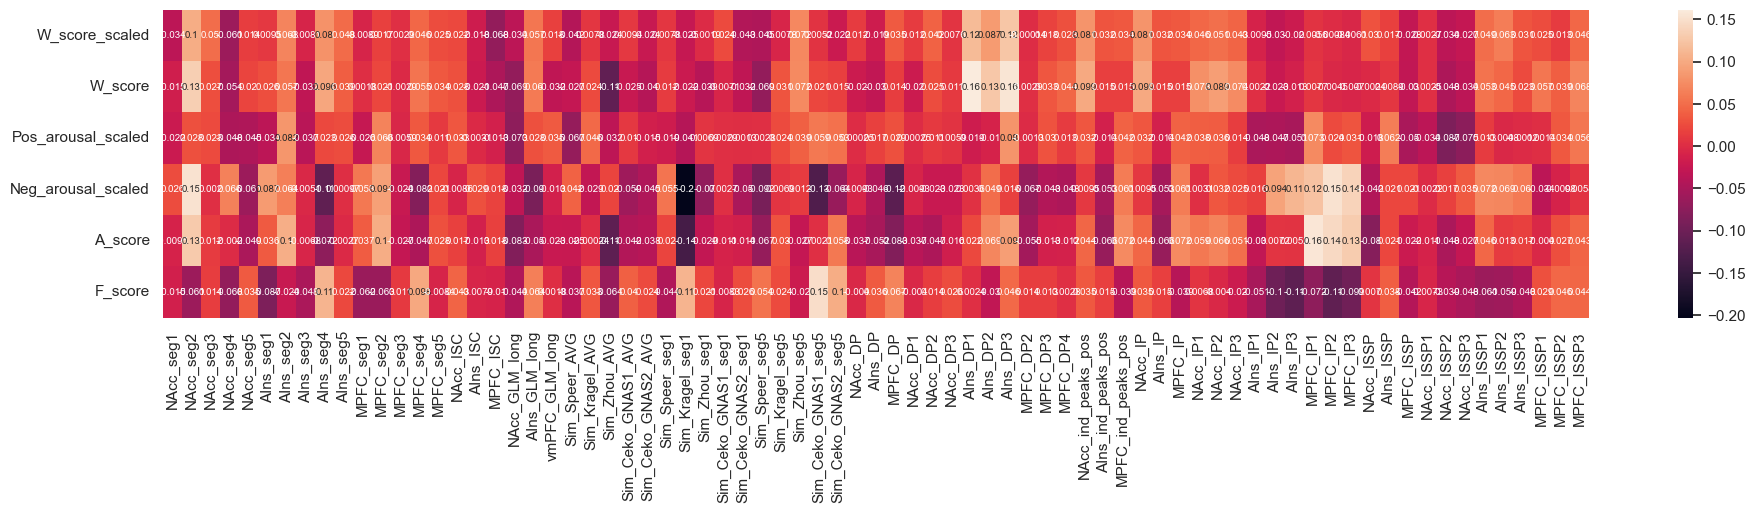

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(23, 4), sharex=False) 

sns.heatmap(all_subs_events_corr.iloc[0:6, 6:], ax=axs, annot=True, annot_kws={'size':7})

<Axes: >

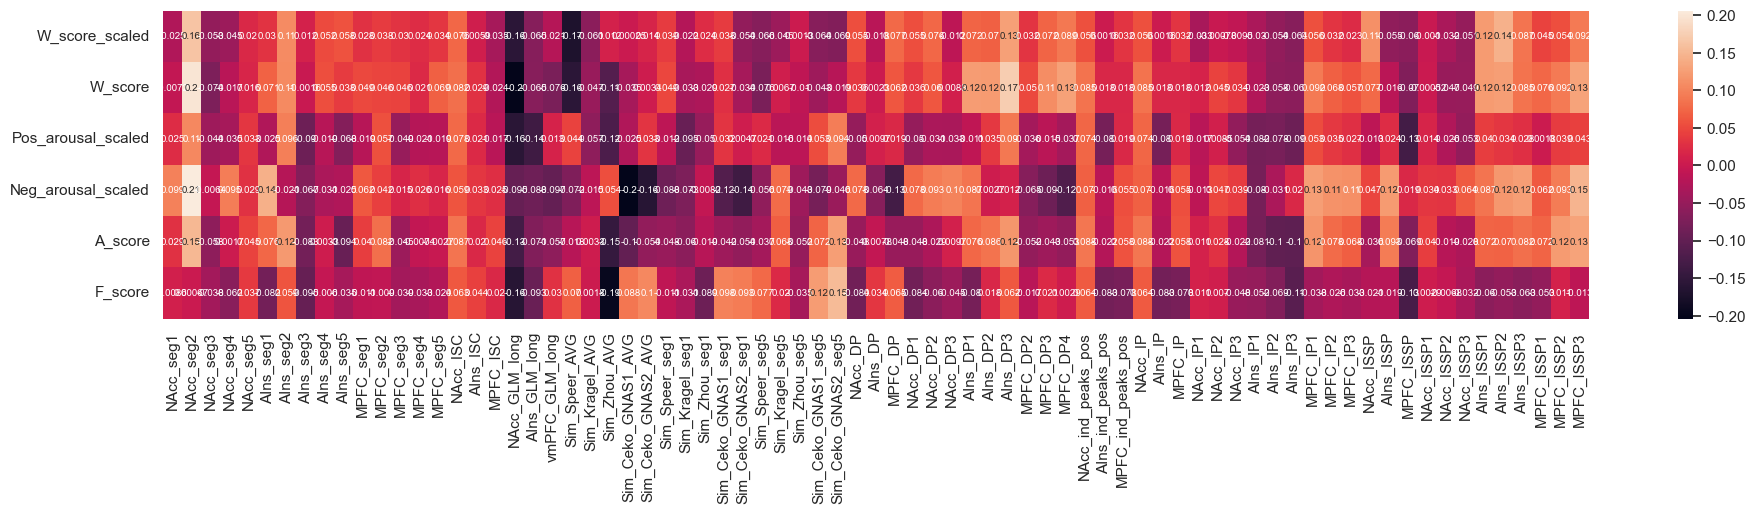

In [94]:
fig, axs = plt.subplots(1, 1, figsize=(23, 4), sharex=False) 

sns.heatmap(all_subs_events_comedy_corr.iloc[0:6, 6:], ax=axs, annot=True, annot_kws={'size':7})

<Axes: >

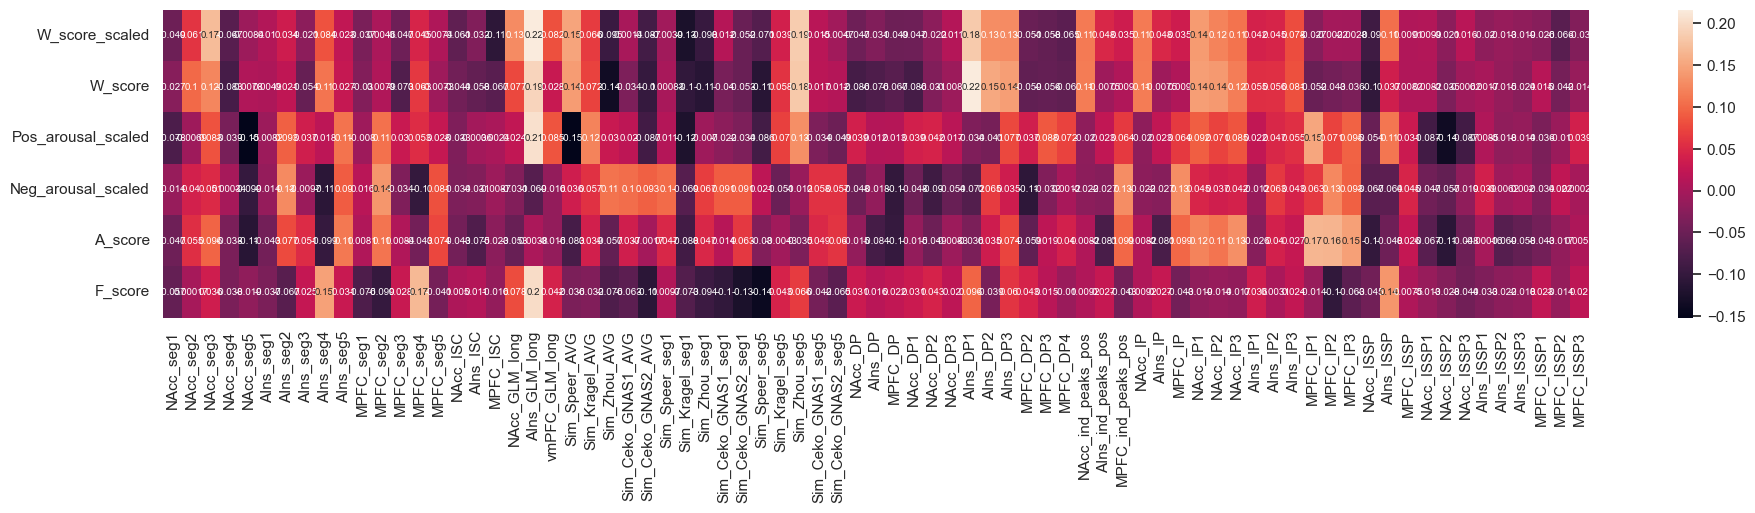

In [95]:
fig, axs = plt.subplots(1, 1, figsize=(23, 4), sharex=False) 

sns.heatmap(all_subs_events_horror_corr.iloc[0:6, 6:], ax=axs, annot=True, annot_kws={'size':7})

In [96]:
all_subs_events_rm_nans_df = all_subs_events_df[["NAcc_IP1", "W_score"]].dropna()


pearsonr(all_subs_events_rm_nans_df["NAcc_IP1"], all_subs_events_rm_nans_df["W_score"])



PearsonRResult(statistic=0.08650879862713466, pvalue=0.007443858072479971)

<Axes: >

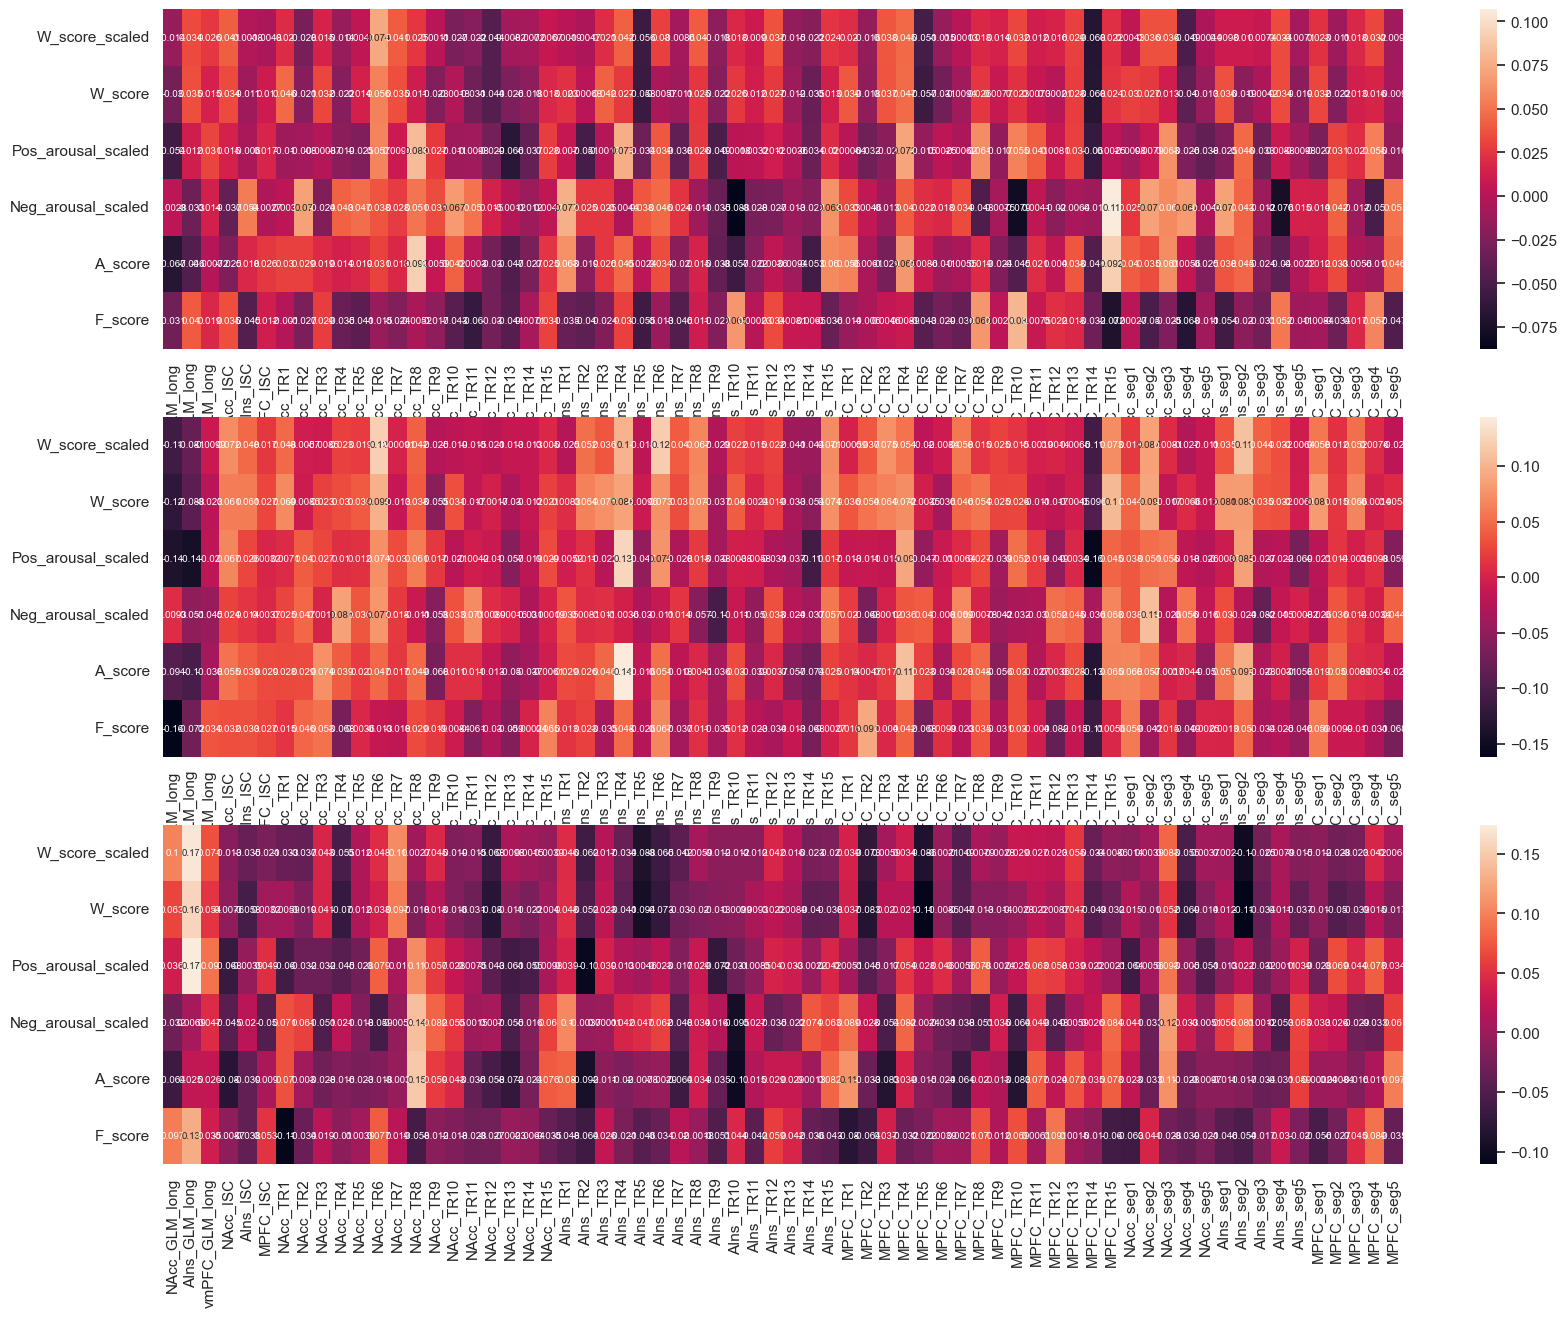

In [97]:
relevant_neuro_cols = ['W_score_scaled', 'W_score', 'Pos_arousal_scaled', 'Neg_arousal_scaled', "A_score", "F_score",
                       "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long",
                       'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
                        
                        "NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15",
                        "AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15",
                        "MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15",

                         "NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
                         "AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
                         "MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5"
                         ]
                        
individual_combined_filtered_df = all_subs_events_df[relevant_neuro_cols]
individual_combined_filtered_df = individual_combined_filtered_df.dropna()
individual_combined_filtered_df = individual_combined_filtered_df.corr()

individual_comedy_filtered_df = all_subs_events_comedy[relevant_neuro_cols]
individual_comedy_filtered_df = individual_comedy_filtered_df.dropna()
individual_comedy_filtered_df = individual_comedy_filtered_df.corr()

individual_horror_filtered_df = all_subs_events_horror[relevant_neuro_cols] 
individual_horror_filtered_df = individual_horror_filtered_df.dropna()
individual_horror_filtered_df = individual_horror_filtered_df.corr()

fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=False) 

sns.heatmap(individual_combined_filtered_df.iloc[0:6, 6:], ax=axs[0], annot=True, annot_kws={'size': 7})
sns.heatmap(individual_comedy_filtered_df.iloc[0:6, 6:], ax=axs[1], annot=True, annot_kws={'size': 7})
sns.heatmap(individual_horror_filtered_df.iloc[0:6, 6:], ax=axs[2], annot=True, annot_kws={'size': 7})

In [98]:
# Check between runs differences. 
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

# Separate df by run. 
# all_subs_events_comedy_r1 = all_subs_events_comedy[all_subs_events_comedy["Trailer"].isin(r1_keys_sorted)]  

# all_subs_events_comedy_r2 = all_subs_events_comedy[all_subs_events_comedy["Trailer"].isin(r2_keys_sorted)]

# TR3_Wscore_both_corr = pearsonr(all_subs_events_comedy["NAcc_TR2"], all_subs_events_comedy["W_score_scaled"])

# TR3_Wscore_r1_corr = pearsonr(all_subs_events_comedy_r1["NAcc_TR2"], all_subs_events_comedy_r1["W_score_scaled"])

# TR3_Wscore_r2_corr = pearsonr(all_subs_events_comedy_r2["NAcc_TR2"], all_subs_events_comedy_r2["W_score_scaled"])

# print("The correlation between NAcc_TR3 and W_score for both runs is: ", TR3_Wscore_both_corr)

# print("The correlation between NAcc_TR3 and W_score for run 1 is: ", TR3_Wscore_r1_corr)

# print("The correlation between NAcc_TR3 and W_score for run 2 is: ", TR3_Wscore_r2_corr)

# NAccDP_Wscore_both_corr = pearsonr(all_subs_events_comedy["NAcc_DP"], all_subs_events_comedy["W_score_scaled"])

# NAccDP_Wscore_r1_corr = pearsonr(all_subs_events_comedy_r1["NAcc_DP"], all_subs_events_comedy_r1["W_score_scaled"])

# NAccDP_Wscore_r2_corr = pearsonr(all_subs_events_comedy_r2["NAcc_DP"], all_subs_events_comedy_r2["W_score_scaled"])

# print("\nThe correlation between NAcc_DP and W_score for both runs is: ", NAccDP_Wscore_both_corr)

# print("The correlation between NAcc_DP and W_score for run 1 is: ", NAccDP_Wscore_r1_corr)

# print("The correlation between NAcc_DP and W_score for run 2 is: ", NAccDP_Wscore_r2_corr)



### Look at Genre preference sub-groups.

<Axes: >

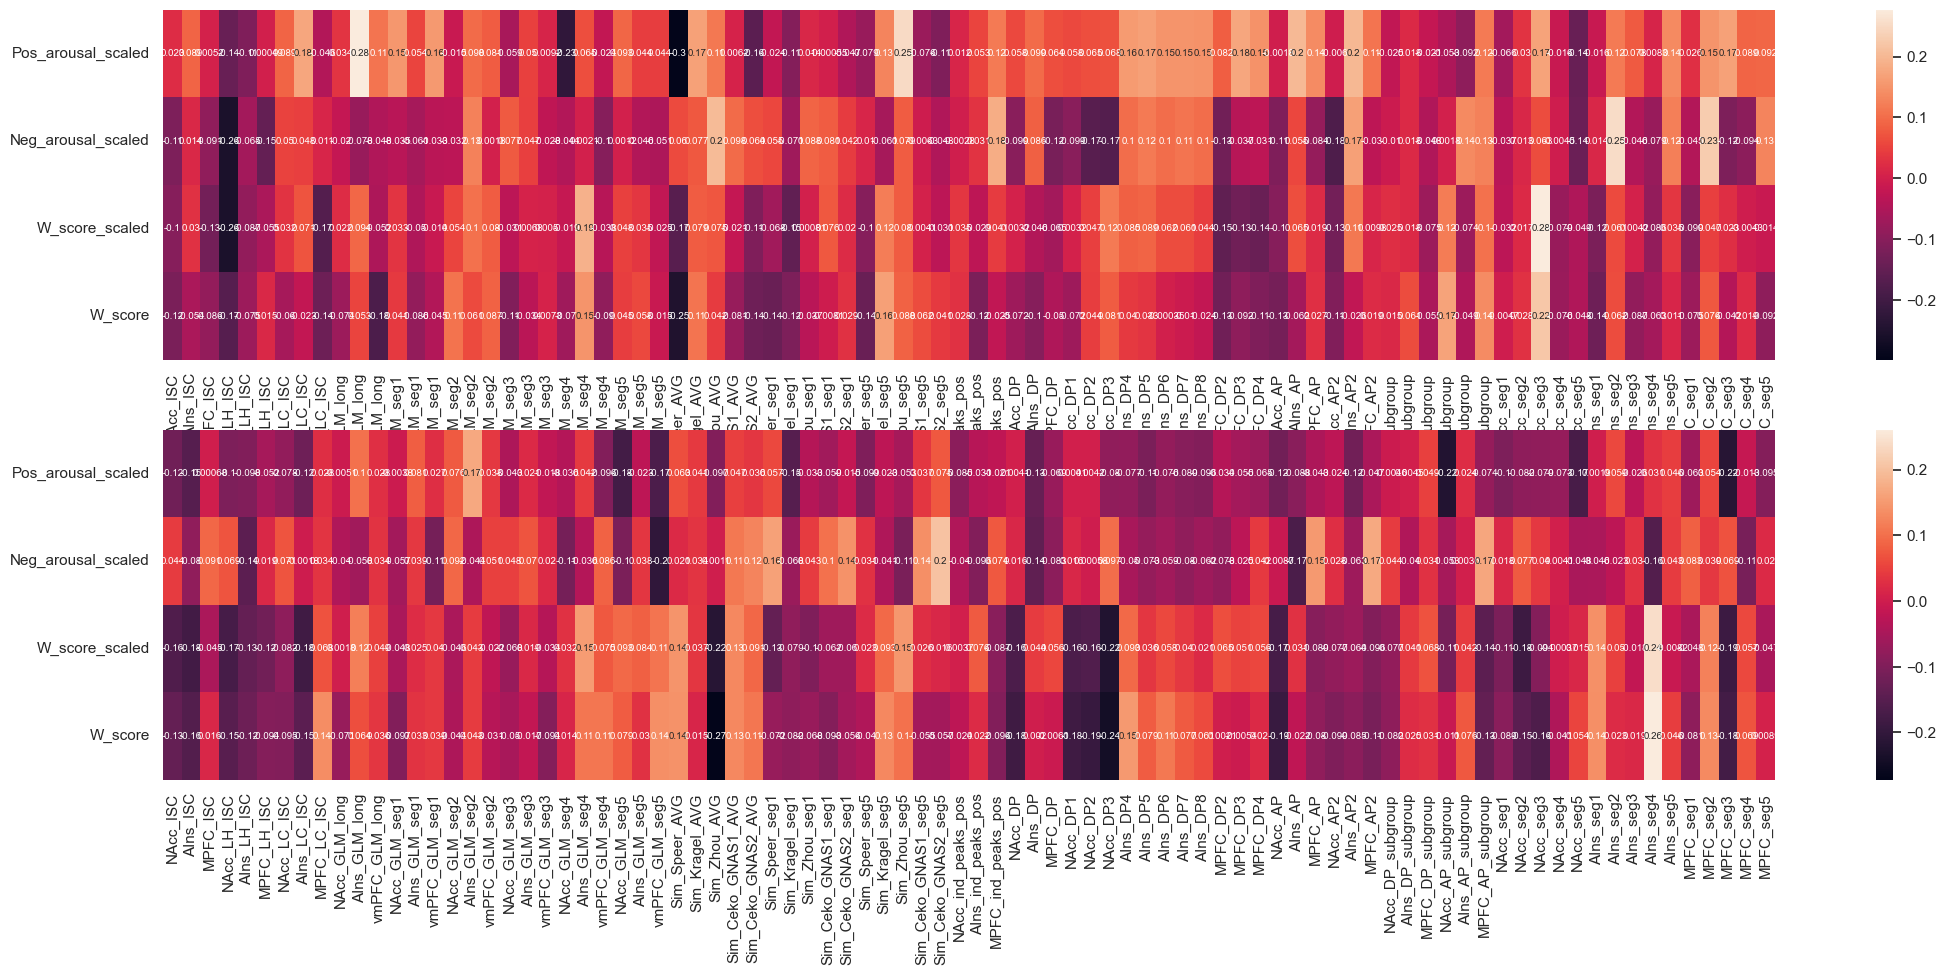

In [99]:


relevant_cols = ['Pos_arousal_scaled', 'Neg_arousal_scaled', 'W_score_scaled', 'W_score', 
       
       #'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle', 'AIns_middle', 'MPFC_middle',
       #'NAcc_offset', 'AIns_offset', 'MPFC_offset',
       "NAcc_ISC", "AIns_ISC", "MPFC_ISC",
       "NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",
       #"NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC",
       #"NAcc_DH_ISC", "AIns_DH_ISC", "MPFC_DH_ISC",
       #"NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_DH_ISC", "AIns_DH_ISC", "MPFC_DH_ISC",
       #"NAcc_w", "AIns_w", #"MPFC_w", "NAcc_f", "AIns_f", "MPFC_f", "NAcc_a", "AIns_a", "MPFC_a", 
       "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", "NAcc_GLM_seg1", "AIns_GLM_seg1", "vmPFC_GLM_seg1",
            "NAcc_GLM_seg2", "AIns_GLM_seg2", "vmPFC_GLM_seg2", "NAcc_GLM_seg3", "AIns_GLM_seg3", "vmPFC_GLM_seg3",
            "NAcc_GLM_seg4", "AIns_GLM_seg4", "vmPFC_GLM_seg4", "NAcc_GLM_seg5", "AIns_GLM_seg5", "vmPFC_GLM_seg5",
           "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
            "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
            "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",
       "NAcc_ind_peaks_pos", "AIns_ind_peaks_pos", "MPFC_ind_peaks_pos",
       
       "NAcc_DP", "AIns_DP", "MPFC_DP",
       "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
       "AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8", 
       "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
       #"NAcc_DPy", "AIns_DPy", "MPFC_DPy",
        #"NAcc_DS", "AIns_DS", "MPFC_DS",
        #"NAcc_DSy", "AIns_DSy", "MPFC_DSy",
        "NAcc_AP", "AIns_AP", "MPFC_AP",
       # AIns_AP4,AIns_AP5,AIns_AP6,AIns_AP7,AIns_AP8,
       # "NAcc_APy", "AIns_APy", "MPFC_APy",
        "NAcc_AP2", "AIns_AP2", "MPFC_AP2", 
        #"NAcc_APy2", "AIns_APy2", "MPFC_APy2",

       "NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
        "NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",

       "NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
       "AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
       "MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5"]

LH_df = LH_df[relevant_cols]
DH_df = DH_df[relevant_cols]

#LH_df["Neuro_NA"] = (LH_df["AIns_avg_peak_pos6"] - (LH_df["NAcc_avg_peak_yes_pos"]/np.sqrt(2)))
#DH_df["Neuro_NA"] = (DH_df["AIns_avg_peak_pos6"] - (DH_df["NAcc_avg_peak_yes_pos"]/np.sqrt(2)))

# LH_df["Neuro_NA2"] = (LH_df["AIns_offset"] - (LH_df["NAcc_dem_peak_pos"]/np.sqrt(2)))
# DH_df["Neuro_NA2"] = (DH_df["AIns_offset"] - (DH_df["NAcc_dem_peak_pos"]/np.sqrt(2)))

# LH_df["Neuro_NA3"] = (-LH_df["AIns_offset"] + (LH_df["NAcc_dem_peak_pos"]/np.sqrt(2)))
# DH_df["Neuro_NA3"] = (-DH_df["AIns_offset"] + (DH_df["NAcc_dem_peak_pos"]/np.sqrt(2)))

# LH_df["Neuro_NA4"] =  (LH_df["AIns_offset"] - (LH_df["NAcc_dem_peak_pos"]/-np.sqrt(3)))
# DH_df["Neuro_NA4"] =  (DH_df["AIns_offset"] - (DH_df["NAcc_dem_peak_pos"]/-np.sqrt(3)))

# LH_df["Neuro_NA5"] = (LH_df["AIns_offset"] - (LH_df["NAcc_dem_peak_pos_yes"]/np.sqrt(2)))
# DH_df["Neuro_NA5"] = (DH_df["AIns_offset"] - (DH_df["NAcc_dem_peak_pos_yes"]/np.sqrt(2)))

#LH_df["Neuro_NA5"] = (LH_df["NAcc_w"]*9) + (LH_df["AIns_w"]*10)
#DH_df["Neuro_NA5"] = (DH_df["AIns_dem_peak_pos"]/np.sqrt(2)) - (DH_df["NAcc_dem_peak_pos"])

#LH_df["Neuro_NA6"] = (LH_df["AIns_dem_peak_neg"]) + (LH_df["NAcc_dem_peak_pos"]/np.sqrt(2))
#DH_df["Neuro_NA6"] = (DH_df["AIns_dem_peak_neg"]) + (DH_df["NAcc_dem_peak_pos"]/np.sqrt(2))


LH_df = LH_df.dropna()
DH_df = DH_df.dropna()

LH_corr = LH_df.corr()
DH_corr = DH_df.corr()

fig, axs = plt.subplots(2, 1, figsize=(26, 10), sharex=False) 

sns.heatmap(LH_corr.iloc[:4, 4:], ax=axs[0], annot=True, annot_kws={'size':7})

sns.heatmap(DH_corr.iloc[:4, 4:], ax=axs[1], annot=True, annot_kws={'size':7})


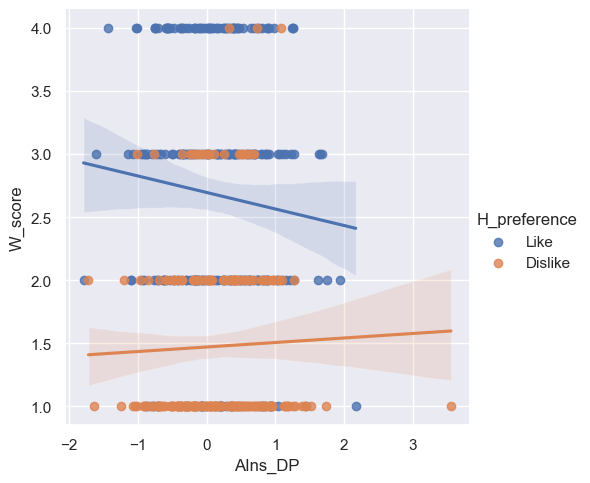

In [100]:
sns.lmplot(data=all_subs_events_horror, x="AIns_DP", y="W_score", hue="H_preference")


<Axes: >

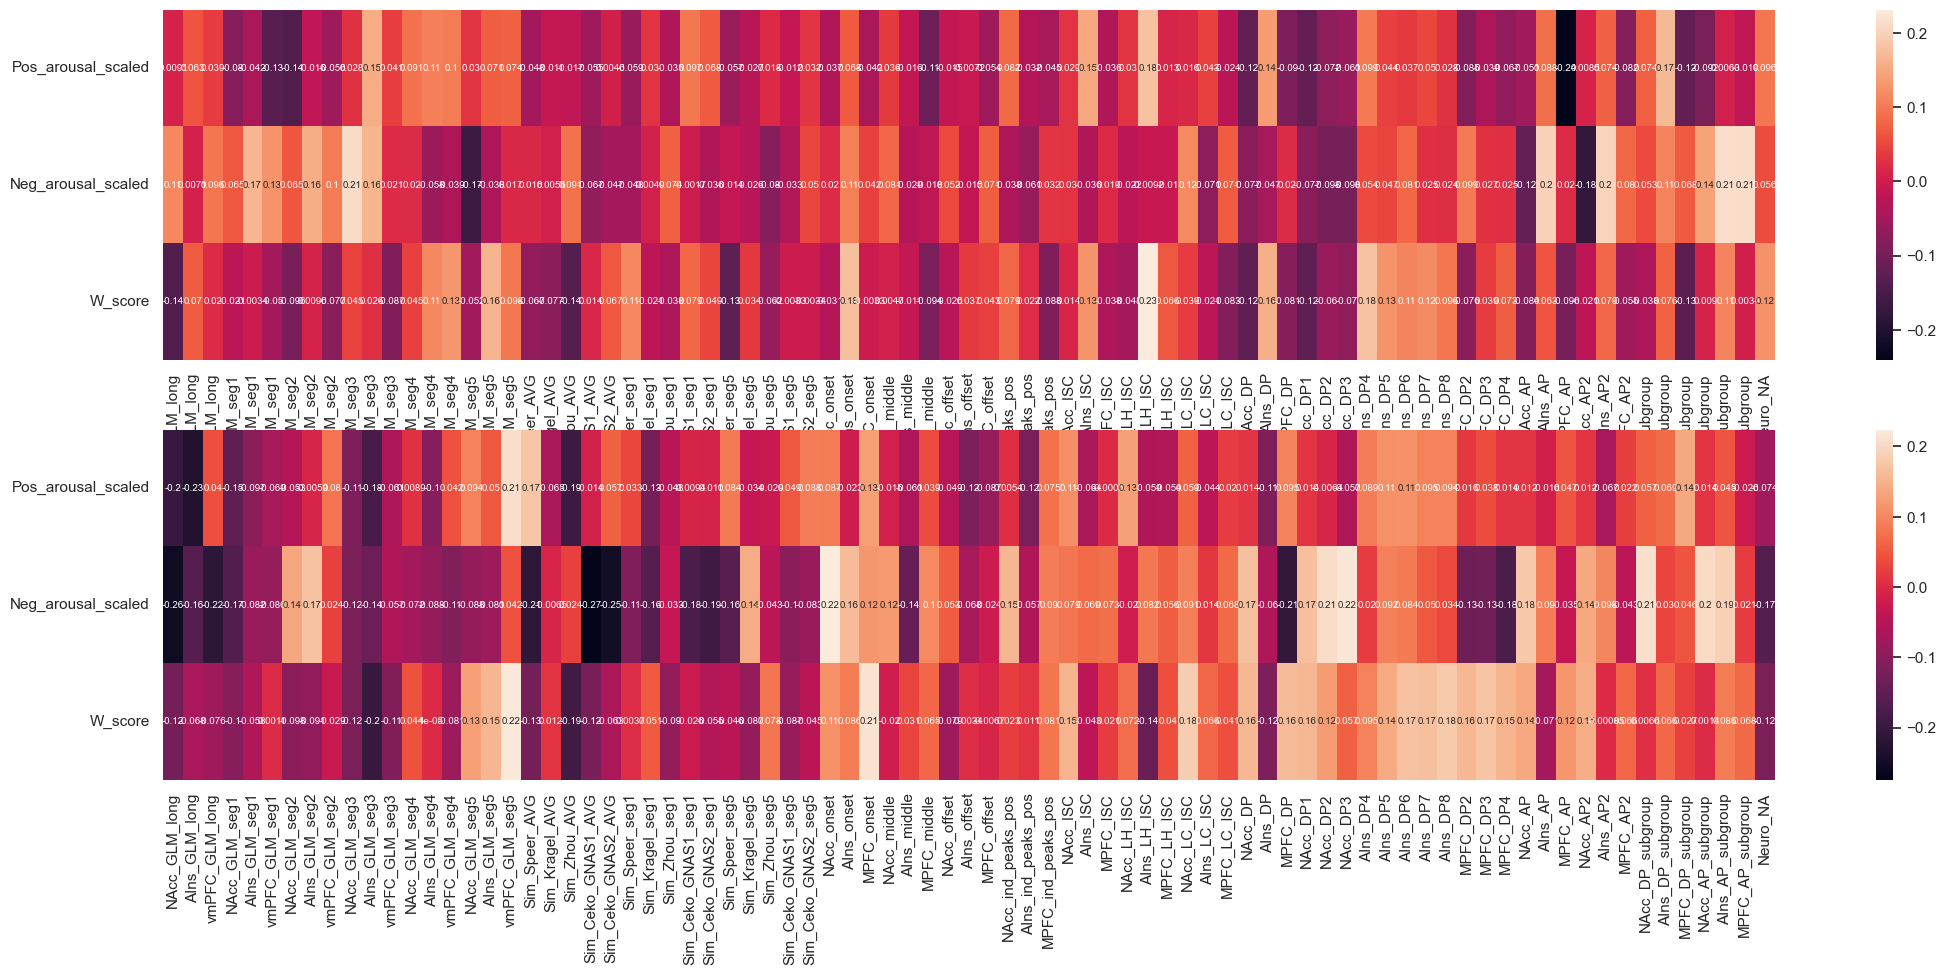

In [101]:
LC_df = all_subs_events_df[(all_subs_events_df["C_preference"] == "Like") & (all_subs_events_df["Type"] == "Comedy")]
DC_df = all_subs_events_df[(all_subs_events_df["C_preference"] == "Dislike") & (all_subs_events_df["Type"] == "Comedy")]

relevant_cols = ['Pos_arousal_scaled', 'Neg_arousal_scaled', 'W_score',
                 "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", "NAcc_GLM_seg1", "AIns_GLM_seg1", "vmPFC_GLM_seg1",
            "NAcc_GLM_seg2", "AIns_GLM_seg2", "vmPFC_GLM_seg2", "NAcc_GLM_seg3", "AIns_GLM_seg3", "vmPFC_GLM_seg3",
            "NAcc_GLM_seg4", "AIns_GLM_seg4", "vmPFC_GLM_seg4", "NAcc_GLM_seg5", "AIns_GLM_seg5", "vmPFC_GLM_seg5",
            "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
            "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
            "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",
         'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle', 'AIns_middle', 'MPFC_middle',
         'NAcc_offset', 'AIns_offset', 'MPFC_offset', 
         "NAcc_ind_peaks_pos", "AIns_ind_peaks_pos", "MPFC_ind_peaks_pos",
         "NAcc_ISC", "AIns_ISC", "MPFC_ISC",
         #"NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC", "NAcc_DC_ISC", "AIns_DC_ISC", "MPFC_DC_ISC",
         "NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",
        "NAcc_DP", "AIns_DP", "MPFC_DP",
        "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
        "AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8", 
        "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
        #"NAcc_DPy", "AIns_DPy", "MPFC_DPy",
        #"NAcc_DS", "AIns_DS", "MPFC_DS",
        #"NAcc_DSy", "AIns_DSy", "MPFC_DSy",
        "NAcc_AP", "AIns_AP", "MPFC_AP",
       # AIns_AP4,AIns_AP5,AIns_AP6,AIns_AP7,AIns_AP8,
        #"NAcc_APy", "AIns_APy", "MPFC_APy",
        "NAcc_AP2", "AIns_AP2", "MPFC_AP2", 
        #"NAcc_APy2", "AIns_APy2", "MPFC_APy2",
        #"NAcc_APy1", "NAcc_APy2", "NAcc_APy3",

        "NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
        "NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",
         # "NAcc_avg_peak_pos2", "AIns_avg_peak_pos2", "MPFC_avg_peak_pos2",
         # "NAcc_avg_peak_yes_pos2" , 'AIns_avg_peak_yes_pos2', 'MPFC_avg_peak_yes_pos2', 
         # 'AIns_dem_peak_pos4', 'AIns_dem_peak_pos5', 'AIns_dem_peak_pos6', 'AIns_dem_peak_pos7',
         # 'AIns_avg_peak_pos4', 'AIns_avg_peak_pos5', 'AIns_avg_peak_pos6', 'AIns_avg_peak_pos7', 'AIns_avg_peak_pos8',
         # 'MPFC_dem_peak_pos2', 'MPFC_dem_peak_pos3', 'MPFC_dem_peak_pos4'
         ]

LC_df = LC_df[relevant_cols]
DC_df = DC_df[relevant_cols]

LC_df["Neuro_NA"] = (LC_df["AIns_offset"] - (LC_df["NAcc_DP"]/np.sqrt(2)))
DC_df["Neuro_NA"] = (DC_df["AIns_offset"] - (DC_df["NAcc_DP"]/np.sqrt(2)))

LC_df = LC_df.dropna()
DC_df = DC_df.dropna()

LC_corr = LC_df.corr()
DC_corr = DC_df.corr()

fig, axs = plt.subplots(2, 1, figsize=(26, 10), sharex=False)

sns.heatmap(LC_corr.iloc[:3, 3:], ax=axs[0], annot=True, annot_kws={'size':7})

sns.heatmap(DC_corr.iloc[:3, 3:], ax=axs[1], annot=True, annot_kws={'size':7})

# Format data for LMM analysis.

In [102]:
# Save data from individual choice analysis. 
#all_subs_events_df.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC.csv')
#all_subs_events_comedy.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC_Comedy.csv')
#all_subs_events_horror.to_csv('RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_ISC_Horror.csv')

In [103]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

root_path = os.getcwd()

Current working dir : /Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData


In [104]:
# # Filter some noise before calculating neural mean activation (for aggregate prediciton).

# drop_threshold1 = 3#2.5#1.25 #3 #1.25 #2.5
# drop_threshold2 = -3#-2.5#-1.25 #-3 #-1.25 #-2.5

# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_onset_z'] < drop_threshold1) | (all_subs_events_df['NAcc_onset_z'] < drop_threshold2) | 
#                                         (all_subs_events_df['AIns_onset_z'] < drop_threshold1) | (all_subs_events_df['AIns_onset_z'] < drop_threshold2) | 
#                                         (all_subs_events_df['MPFC_onset_z'] < drop_threshold1) | (all_subs_events_df['MPFC_onset_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_middle_z'] < drop_threshold1) | (all_subs_events_df['NAcc_middle_z'] < drop_threshold2) | 
#                                         (all_subs_events_df['AIns_middle_z'] < drop_threshold1) | (all_subs_events_df['AIns_middle_z'] < drop_threshold2) | 
#                                         (all_subs_events_df['MPFC_middle_z'] < drop_threshold1) | (all_subs_events_df['MPFC_middle_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_offset_z'] < drop_threshold1) | (all_subs_events_df['NAcc_offset_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_offset_z'] < drop_threshold1) | (all_subs_events_df['AIns_offset_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_offset_z'] < drop_threshold1) | (all_subs_events_df['MPFC_offset_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_whole_z'] < drop_threshold1) | (all_subs_events_df['NAcc_whole_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_whole_z'] < drop_threshold1) | (all_subs_events_df['AIns_whole_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_whole_z'] < drop_threshold1) | (all_subs_events_df['MPFC_whole_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_ind_peaks_pos_z'] < drop_threshold1) | (all_subs_events_df['NAcc_ind_peaks_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_ind_peaks_pos_z'] < drop_threshold1) | (all_subs_events_df['AIns_ind_peaks_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_ind_peaks_pos_z'] < drop_threshold1) | (all_subs_events_df['MPFC_ind_peaks_pos_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_dem_peak_pos_z'] < drop_threshold1) | (all_subs_events_df['NAcc_dem_peak_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_dem_peak_pos_z'] < drop_threshold1) | (all_subs_events_df['AIns_dem_peak_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_dem_peak_pos_z'] < drop_threshold1) | (all_subs_events_df['MPFC_dem_peak_pos_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_dem_peak_pos_yes_z'] < drop_threshold1) | (all_subs_events_df['NAcc_dem_peak_pos_yes_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_dem_peak_pos_yes_z'] < drop_threshold1) | (all_subs_events_df['AIns_dem_peak_pos_yes_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_dem_peak_pos_yes_z'] < drop_threshold1) | (all_subs_events_df['MPFC_dem_peak_pos_yes_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_avg_peak_pos_z'] < drop_threshold1) | (all_subs_events_df['NAcc_avg_peak_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_avg_peak_pos_z'] < drop_threshold1) | (all_subs_events_df['AIns_avg_peak_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_avg_peak_pos_z'] < drop_threshold1) | (all_subs_events_df['MPFC_avg_peak_pos_z'] < drop_threshold2)]
# all_subs_events_df = all_subs_events_df[(all_subs_events_df['NAcc_avg_peak_yes_pos_z'] < drop_threshold1) | (all_subs_events_df['NAcc_avg_peak_yes_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['AIns_avg_peak_yes_pos_z'] < drop_threshold1) | (all_subs_events_df['AIns_avg_peak_yes_pos_z'] < drop_threshold2) |
#                                         (all_subs_events_df['MPFC_avg_peak_yes_pos_z'] < drop_threshold1) | (all_subs_events_df['MPFC_avg_peak_yes_pos_z'] < drop_threshold2)]

# print("The shape of the dataframe after dropping rows is: ", all_subs_events_df.shape)

In [105]:

# Add watch choice. 

all_subs_events_df["Watch_choice"] = np.where(all_subs_events_df["W_score"] < 3, "No", "Yes")



In [106]:
print(all_subs_events_df[["NAcc_DP", "AIns_DP", "MPFC_DP",
        "NAcc_DP1", "NAcc_DP2", "NAcc_DP3"]].isna().sum())

NAcc_DP     36
AIns_DP     44
MPFC_DP     37
NAcc_DP1    36
NAcc_DP2    26
NAcc_DP3    20
dtype: int64


In [107]:
all_subs_events_df.head()

Participant Trailer    Type  W_score  A_score  F_score  NAcc_onset  \
0      sub-01     rh6  Horror      3.0      3.0      2.0    0.396752   
1      sub-01     uh1  Horror      1.0      3.0      3.0    0.098696   
2      sub-01     rc2  Comedy      1.0      1.0      3.0   -1.063516   
3      sub-01     rh2  Horror      3.0      2.0      2.0    0.637617   
4      sub-01     rh1  Horror      4.0      3.0      2.0   -0.452684   

   AIns_onset  MPFC_onset  NAcc_middle  ...  Sim_Zhou_seg1  \
0    0.657827    0.759440    -0.666929  ...       0.029547   
1    0.295622    0.136385    -0.098751  ...       0.017056   
2   -1.059873   -0.015051     0.222832  ...       0.015643   
3   -0.650366   -0.676718     0.005747  ...      -0.016697   
4    0.155205   -0.119316     0.034977  ...      -0.033895   

   Sim_Ceko_GNAS1_seg1  Sim_Ceko_GNAS2_seg1  Sim_Speer_seg5  Sim_Kragel_seg5  \
0            -0.025011            -0.025846       -0.066598        -0.001268   
1            -0.013382            -0.029733       -0.070944         0.013172   
2             0.002686             0.016118       -0.064964        -0.003612   
3            -0.002956            -0.005773       -0.043432        -0.017301   
4            -0.007844             0.008693        0.011330         0.011759   

   Sim_Zhou_seg5  Sim_Ceko_GNAS1_seg5  Sim_Ceko_GNAS2_seg5  H_preference  \
0      -0.040712             0.031819             0.037773          Like   
1      -0.010922             0.026703             0.020526          Like   
2       0.052806             0.024070             0.036442          Like   
3       0.022471             0.016936             0.014827          Like   
4      -0.014826             0.015716             0.030278          Like   

   C_preference  
0       Dislike  
1       Dislike  
2       Dislike  
3       Dislike  
4       Dislike  

[5 rows x 349 columns]

In [108]:
# Get average neural signals for each trailer. 
numeric_cols_agg = all_subs_events_df.select_dtypes(include=['number']).columns
aggregate_df = all_subs_events_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg].mean()
aggregate_df.reset_index(inplace=True)

# Aggregate std 
aggregate_std_df = all_subs_events_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg].std()
aggregate_std_df.reset_index(inplace=True)

# Create df with only people that said 'yes' to Watch questions. 
all_participants_cleaned_yes_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "Yes"]

numeric_cols_agg2 = all_participants_cleaned_yes_df.select_dtypes(include=['number']).columns
aggregate_yes_df = all_participants_cleaned_yes_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg2].mean()
aggregate_yes_df.reset_index(inplace=True)

numeric_cols_agg3 = Like_horror_df.select_dtypes(include=['number']).columns
Like_horror_aggreate_df = Like_horror_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg3].mean()
Like_horror_aggreate_df.reset_index(inplace=True)
Like_horror_aggreate_df["Type"] = "horror"

# Get average for Like-Comedy (LC).
LC_df = all_subs_events_df[(all_subs_events_df["C_preference"] == "Like") & (all_subs_events_df["Type"] == "Comedy")]
LC_aggregate_df = LC_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg3].mean()
LC_aggregate_df.reset_index(inplace=True)
LC_aggregate_df["Type"] = "comedy"

LC_yes_df = all_subs_events_df[(all_subs_events_df["Watch_choice"] == "Yes") & (all_subs_events_df["Type"] == "Comedy")]
LC_aggregate_yes_df = LC_yes_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg3].mean()
LC_aggregate_yes_df.reset_index(inplace=True)
LC_aggregate_yes_df["Type"] = "comedy"

# Get average for Like-Horror (LH).
LH_df = all_subs_events_df[(all_subs_events_df["H_preference"] == "Like") & (all_subs_events_df["Type"] == "Horror")]
LH_aggregate_df = LH_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg3].mean()
LH_aggregate_df.reset_index(inplace=True)
LH_aggregate_df["Type"] = "horror"

LH_yes_df = all_subs_events_df[(all_subs_events_df["Watch_choice"] == "Yes") & (all_subs_events_df["Type"] == "Horror")]
LH_aggregate_yes_df = LH_yes_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg3].mean()
LH_aggregate_yes_df.reset_index(inplace=True)
LH_aggregate_yes_df["Type"] = "horror"






In [109]:
# Create lists to store values. 
NAcc_trailer_peak_pos = []
AIns_trailer_peak_pos = []
MPFC_trailer_peak_pos = []

NAcc_trailer_peak_pos_id = []
AIns_trailer_peak_pos_id = []
MPFC_trailer_peak_pos_id = []

NAcc_trailer_peak_pos_yes = []
AIns_trailer_peak_pos_yes = []
MPFC_trailer_peak_pos_yes = []

# Define keys. 
NAcc_TRs_keys = ['NAcc_TR1', 'NAcc_TR2', 'NAcc_TR3', 'NAcc_TR4', 'NAcc_TR5', 
                'NAcc_TR6', 'NAcc_TR7', 'NAcc_TR8', 'NAcc_TR9', 'NAcc_TR10',
                'NAcc_TR11', 'NAcc_TR12', 'NAcc_TR13', 'NAcc_TR14', 'NAcc_TR15']

AIns_TRs_keys = ['AIns_TR1', 'AIns_TR2', 'AIns_TR3', 'AIns_TR4', 'AIns_TR5',
                'AIns_TR6', 'AIns_TR7', 'AIns_TR8', 'AIns_TR9', 'AIns_TR10',
                'AIns_TR11', 'AIns_TR12', 'AIns_TR13', 'AIns_TR14', 'AIns_TR15']

MPFC_TRs_keys = ['MPFC_TR1', 'MPFC_TR2', 'MPFC_TR3', 'MPFC_TR4', 'MPFC_TR5',
                'MPFC_TR6', 'MPFC_TR7', 'MPFC_TR8', 'MPFC_TR9', 'MPFC_TR10',
                'MPFC_TR11', 'MPFC_TR12', 'MPFC_TR13', 'MPFC_TR14', 'MPFC_TR15']

# Calculate each trailer peak activation.
for trailer_id in range(aggregate_df.shape[0]):
    
    # Get time course for each region.
    NAcc_time_course = np.array(aggregate_df.iloc[trailer_id][NAcc_TRs_keys]).flatten()
    AIns_time_course = np.array(aggregate_df.iloc[trailer_id][AIns_TRs_keys]).flatten()
    MPFC_time_course = np.array(aggregate_df.iloc[trailer_id][MPFC_TRs_keys]).flatten()

    NAcc_time_course_yes = np.array(aggregate_yes_df.iloc[trailer_id][NAcc_TRs_keys]).flatten()
    AIns_time_course_yes = np.array(aggregate_yes_df.iloc[trailer_id][AIns_TRs_keys]).flatten()
    MPFC_time_course_yes = np.array(aggregate_yes_df.iloc[trailer_id][MPFC_TRs_keys]).flatten()

    # Get peak activation for each region.
    NAcc_peak_pos, NAcc_peak_pos_id = get_trailer_peak(NAcc_time_course, "max")
    AIns_peak_pos, AIns_peak_pos_id = get_trailer_peak(AIns_time_course, "max")
    MPFC_peak_pos, MPFC_peak_pos_id = get_trailer_peak(MPFC_time_course, "max")

    # NAcc_peak_neg = get_trailer_peak(NAcc_time_course, "min")
    # AIns_peak_neg = get_trailer_peak(AIns_time_course, "min")
    # MPFC_peak_neg = get_trailer_peak(MPFC_time_course, "min")

    NAcc_peak_pos_yes, _ = get_trailer_peak(NAcc_time_course_yes, "max")
    AIns_peak_pos_yes, _ = get_trailer_peak(AIns_time_course_yes, "max")
    MPFC_peak_pos_yes, _ = get_trailer_peak(MPFC_time_course_yes, "max")

    # Append values to lists.
    NAcc_trailer_peak_pos.append(NAcc_peak_pos)
    AIns_trailer_peak_pos.append(AIns_peak_pos)
    MPFC_trailer_peak_pos.append(MPFC_peak_pos)

    NAcc_trailer_peak_pos_id.append(NAcc_peak_pos_id)
    AIns_trailer_peak_pos_id.append(AIns_peak_pos_id)
    MPFC_trailer_peak_pos_id.append(MPFC_peak_pos_id)

    # NAcc_trailer_peak_neg.append(NAcc_peak_neg)
    # AIns_trailer_peak_neg.append(AIns_peak_neg)
    # MPFC_trailer_peak_neg.append(MPFC_peak_neg)

    NAcc_trailer_peak_pos_yes.append(NAcc_peak_pos_yes)
    AIns_trailer_peak_pos_yes.append(AIns_peak_pos_yes)
    MPFC_trailer_peak_pos_yes.append(MPFC_peak_pos_yes)

# Add values to dataframe.
aggregate_df["NAcc_trailer_peak_pos"] = NAcc_trailer_peak_pos
aggregate_df["AIns_trailer_peak_pos"] = AIns_trailer_peak_pos
aggregate_df["MPFC_trailer_peak_pos"] = MPFC_trailer_peak_pos

aggregate_df["NAcc_trailer_peak_pos_id"] = NAcc_trailer_peak_pos_id
aggregate_df["AIns_trailer_peak_pos_id"] = AIns_trailer_peak_pos_id
aggregate_df["MPFC_trailer_peak_pos_id"] = MPFC_trailer_peak_pos_id

# aggregate_df["NAcc_trailer_peak_neg"] = NAcc_trailer_peak_neg
# aggregate_df["AIns_trailer_peak_neg"] = AIns_trailer_peak_neg
# aggregate_df["MPFC_trailer_peak_neg"] = MPFC_trailer_peak_neg

aggregate_df["NAcc_trailer_peak_pos_yes"] = NAcc_trailer_peak_pos_yes
aggregate_df["AIns_trailer_peak_pos_yes"] = AIns_trailer_peak_pos_yes
aggregate_df["MPFC_trailer_peak_pos_yes"] = MPFC_trailer_peak_pos_yes

aggregate_df.head()

index Trailer   W_score   A_score   F_score  NAcc_onset  AIns_onset  \
0      0     rc1  3.031250  2.531250  3.531250    0.022663    0.019752   
1      1    rc10  2.266667  2.000000  3.066667   -0.099348    0.047899   
2      2    rc11  2.062500  1.750000  3.281250    0.028563    0.058575   
3      3    rc12  1.870968  1.677419  2.870968   -0.062832    0.027690   
4      4     rc2  1.968750  1.750000  2.906250    0.050241    0.060156   

   MPFC_onset  NAcc_middle  AIns_middle  ...  Sim_Ceko_GNAS2_seg5  \
0    0.050734     0.024396     0.119719  ...             0.001422   
1   -0.006971    -0.046488     0.052685  ...             0.010206   
2    0.047439    -0.046842    -0.007663  ...             0.005230   
3    0.042151    -0.098285    -0.021475  ...             0.009632   
4    0.099025    -0.039973    -0.055941  ...            -0.001008   

   NAcc_trailer_peak_pos  AIns_trailer_peak_pos  MPFC_trailer_peak_pos  \
0               0.111728               0.065460               0.145344   
1               0.094243               0.117852               0.041598   
2               0.069082               0.096577               0.025692   
3              -0.047791               0.057941               0.059314   
4               0.182075               0.081317               0.101519   

   NAcc_trailer_peak_pos_id  AIns_trailer_peak_pos_id  \
0                         5                         3   
1                        11                         2   
2                         2                        13   
3                        11                         8   
4                         0                         3   

   MPFC_trailer_peak_pos_id  NAcc_trailer_peak_pos_yes  \
0                         6                   0.141506   
1                         5                   0.236640   
2                        13                   0.089443   
3                         4                   0.259190   
4                         2                   0.164552   

   AIns_trailer_peak_pos_yes  MPFC_trailer_peak_pos_yes  
0                   0.072764                   0.183042  
1                   0.235977                   0.157521  
2                   0.171710                   0.187613  
3                   0.652694                   0.093598  
4                   0.352045                   0.629321  

[5 rows x 354 columns]

In [110]:
# Get list of trailers in dataframe.
all_trailer_list = aggregate_df["Trailer"].unique().tolist()
horror_trailer_list = aggregate_df["Trailer"].unique().tolist()
comedy_trailer_list = LC_df["Trailer"].unique().tolist()

# Calculate trailer peak for horror sub-group. 
NAcc_trailer_peak_pos_LH = []
AIns_trailer_peak_pos_LH = []
MPFC_trailer_peak_pos_LH = []

NAcc_trailer_peak_yes_LH = []
AIns_trailer_peak_yes_LH = []
MPFC_trailer_peak_yes_LH = []

# Calculate each trailer peak activation.
for num_id in range(LH_aggregate_df.shape[0]):

    NAcc_time_course_LH = np.array(LH_aggregate_df.iloc[num_id][NAcc_TRs_keys]).flatten()
    AIns_time_course_LH = np.array(LH_aggregate_df.iloc[num_id][AIns_TRs_keys]).flatten()
    MPFC_time_course_LH = np.array(LH_aggregate_df.iloc[num_id][MPFC_TRs_keys]).flatten()

    NAcc_time_course_yes_LH = np.array(LH_aggregate_yes_df.iloc[num_id][NAcc_TRs_keys]).flatten()
    AIns_time_course_yes_LH = np.array(LH_aggregate_yes_df.iloc[num_id][AIns_TRs_keys]).flatten()
    MPFC_time_course_yes_LH = np.array(LH_aggregate_yes_df.iloc[num_id][MPFC_TRs_keys]).flatten()

    NAcc_peak_pos_LH, _ = get_trailer_peak(NAcc_time_course_LH, "max")
    AIns_peak_pos_LH, _ = get_trailer_peak(AIns_time_course_LH, "max")
    MPFC_peak_pos_LH, _ = get_trailer_peak(MPFC_time_course_LH, "max")

    NAcc_peak_pos_yes_LH, _ = get_trailer_peak(NAcc_time_course_yes_LH, "max")
    AIns_peak_pos_yes_LH, _ = get_trailer_peak(AIns_time_course_yes_LH, "max")
    MPFC_peak_pos_yes_LH, _ = get_trailer_peak(MPFC_time_course_yes_LH, "max")

    NAcc_trailer_peak_pos_LH.append(NAcc_peak_pos_LH)
    AIns_trailer_peak_pos_LH.append(AIns_peak_pos_LH)
    MPFC_trailer_peak_pos_LH.append(MPFC_peak_pos_LH)

    NAcc_trailer_peak_yes_LH.append(NAcc_peak_pos_yes_LH)
    AIns_trailer_peak_yes_LH.append(AIns_peak_pos_yes_LH)
    MPFC_trailer_peak_yes_LH.append(MPFC_peak_pos_yes_LH)

LH_aggregate_df["NAcc_trailer_peak_pos"] = NAcc_trailer_peak_pos_LH
LH_aggregate_df["AIns_trailer_peak_pos"] = AIns_trailer_peak_pos_LH
LH_aggregate_df["MPFC_trailer_peak_pos"] = MPFC_trailer_peak_pos_LH

LH_aggregate_df["NAcc_trailer_peak_pos_yes"] = NAcc_trailer_peak_yes_LH 
LH_aggregate_df["AIns_trailer_peak_pos_yes"] = AIns_trailer_peak_yes_LH
LH_aggregate_df["MPFC_trailer_peak_pos_yes"] = MPFC_trailer_peak_yes_LH



In [111]:
# Calculate trailer peak for comedy sub-group. 
NAcc_trailer_peak_pos_LC = []
AIns_trailer_peak_pos_LC = []
MPFC_trailer_peak_pos_LC = []

NAcc_trailer_peak_yes_LC = []
AIns_trailer_peak_yes_LC = []
MPFC_trailer_peak_yes_LC = []

# Calculate each trailer peak activation.
for trailer_id in range(LC_df["Trailer"].unique().shape[0]):

    NAcc_time_course_LC = np.array(LC_aggregate_df.iloc[trailer_id][NAcc_TRs_keys]).flatten()
    AIns_time_course_LC = np.array(LC_aggregate_df.iloc[trailer_id][AIns_TRs_keys]).flatten()
    MPFC_time_course_LC = np.array(LC_aggregate_df.iloc[trailer_id][MPFC_TRs_keys]).flatten()

    NAcc_time_course_yes_LC = np.array(LC_aggregate_yes_df.iloc[trailer_id][NAcc_TRs_keys]).flatten()
    AIns_time_course_yes_LC = np.array(LC_aggregate_yes_df.iloc[trailer_id][AIns_TRs_keys]).flatten()
    MPFC_time_course_yes_LC = np.array(LC_aggregate_yes_df.iloc[trailer_id][MPFC_TRs_keys]).flatten()

    NAcc_peak_pos_LC, _ = get_trailer_peak(NAcc_time_course_LC, "max")
    AIns_peak_pos_LC, _ = get_trailer_peak(AIns_time_course_LC, "max")
    MPFC_peak_pos_LC, _ = get_trailer_peak(MPFC_time_course_LC, "max")

    NAcc_peak_pos_yes_LC, _ = get_trailer_peak(NAcc_time_course_yes_LC, "max")
    AIns_peak_pos_yes_LC, _ = get_trailer_peak(AIns_time_course_yes_LC, "max")
    MPFC_peak_pos_yes_LC, _ = get_trailer_peak(MPFC_time_course_yes_LC, "max")

    NAcc_trailer_peak_pos_LC.append(NAcc_peak_pos_LC)
    AIns_trailer_peak_pos_LC.append(AIns_peak_pos_LC)
    MPFC_trailer_peak_pos_LC.append(MPFC_peak_pos_LC)

    NAcc_trailer_peak_yes_LC.append(NAcc_peak_pos_yes_LC)
    AIns_trailer_peak_yes_LC.append(AIns_peak_pos_yes_LC)
    MPFC_trailer_peak_yes_LC.append(MPFC_peak_pos_yes_LC)

LC_aggregate_df["NAcc_trailer_peak_pos"] = NAcc_trailer_peak_pos_LC
LC_aggregate_df["AIns_trailer_peak_pos"] = AIns_trailer_peak_pos_LC
LC_aggregate_df["MPFC_trailer_peak_pos"] = MPFC_trailer_peak_pos_LC

LC_aggregate_df["NAcc_trailer_peak_pos_yes"] = NAcc_trailer_peak_yes_LC
LC_aggregate_df["AIns_trailer_peak_pos_yes"] = AIns_trailer_peak_yes_LC
LC_aggregate_df["MPFC_trailer_peak_pos_yes"] = MPFC_trailer_peak_yes_LC



In [112]:
# After dropping outliers from the neural activation data, save the new dataframe to a csv file.
# Calculate the mean measures for each trailer accross participants.
#aggregate_df = all_participants_cleaned_df.groupby("Trailer", as_index=False, dropna=False).mean()
#aggregate_df.reset_index(inplace=True)

# Add "Type" column to the dataframe.
aggregate_df["Type"] = np.where(aggregate_df["Trailer"].str.contains("h"), "horror", "comedy")

# type_list = []
# for id_trailer in range(len(aggregate_df)):
#     if "c" in aggregate_df["Trailer"][id_trailer]:
#         type_list.append("comedy")
#     else:
#         type_list.append("horror")

# aggregate_df["Type"] = type_list


# Re-order columns.
cols_ordered = ['Trailer', 'Type', #'Onset', 'Offset', 
                'Pos_arousal', 'Neg_arousal',
        'Pos_arousal_scaled', 'Neg_arousal_scaled', 'W_score', 'W_score_scaled',
        'NAcc_onset', 'AIns_onset', 'MPFC_onset',
        'NAcc_middle', 'AIns_middle', 'MPFC_middle', 'NAcc_offset',
        'AIns_offset', 'MPFC_offset', 'NAcc_whole', 'AIns_whole', 'MPFC_whole',
        #'NAcc_onset_z', 'AIns_onset_z', 'MPFC_onset_z', 'NAcc_middle_z',
        #'AIns_middle_z', 'MPFC_middle_z', 'NAcc_offset_z', 'AIns_offset_z',
        #'MPFC_offset_z',v'NAcc_whole_z', 'AIns_whole_z', 'MPFC_whole_z', 
        "NAcc_ind_peaks_pos", "AIns_ind_peaks_pos", "MPFC_ind_peaks_pos",
        #"NAcc_ind_peaks_neg", "AIns_ind_peaks_neg", "MPFC_ind_peaks_neg",
        "NAcc_trailer_peak_pos", "AIns_trailer_peak_pos", "MPFC_trailer_peak_pos",
        #"NAcc_trailer_peak_pos_id", "AIns_trailer_peak_pos_id", "MPFC_trailer_peak_pos_id",
        #"NAcc_trailer_peak_neg", "AIns_trailer_peak_neg", "MPFC_trailer_peak_neg",
        "NAcc_trailer_peak_pos_yes", "AIns_trailer_peak_pos_yes", "MPFC_trailer_peak_pos_yes",
        #'NAcc_pos_peak','AIns_pos_peak', 'MPFC_pos_peak', 
        #'NAcc_neg_peak','AIns_neg_peak', 'MPFC_neg_peak',
        #'NAcc_w', 'AIns_w', 'MPFC_w', 'NAcc_f', 'AIns_f', 'MPFC_f',
        #'NAcc_a', 'AIns_a', 'MPFC_a', 
        'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
        "NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",
        "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", "NAcc_GLM_seg1", "AIns_GLM_seg1", "vmPFC_GLM_seg1",
            "NAcc_GLM_seg2", "AIns_GLM_seg2", "vmPFC_GLM_seg2", "NAcc_GLM_seg3", "AIns_GLM_seg3", "vmPFC_GLM_seg3",
            "NAcc_GLM_seg4", "AIns_GLM_seg4", "vmPFC_GLM_seg4", "NAcc_GLM_seg5", "AIns_GLM_seg5", "vmPFC_GLM_seg5",
            "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
            "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
            "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",
        "NAcc_DP", "AIns_DP", "MPFC_DP",
        "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
        "AIns_DP1", "AIns_DP2", "AIns_DP3", "AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8",
        "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
        "NAcc_DPy", "AIns_DPy", "MPFC_DPy",
        "NAcc_DPy1", "NAcc_DPy2", "NAcc_DPy3",

        "NAcc_IP", "AIns_IP", "MPFC_IP",
        "NAcc_IP1", "NAcc_IP2", "NAcc_IP3",
        "AIns_IP1", "AIns_IP2", "AIns_IP3",
        "MPFC_IP1", "MPFC_IP2", "MPFC_IP3",

        "NAcc_ISSP", "AIns_ISSP", "MPFC_ISSP",
       "NAcc_ISSP1", "NAcc_ISSP2", "NAcc_ISSP3",
        "AIns_ISSP1", "AIns_ISSP2", "AIns_ISSP3",
        "MPFC_ISSP1", "MPFC_ISSP2", "MPFC_ISSP3",

        #"NAcc_DS", "AIns_DS", "MPFC_DS",
        #"NAcc_DSy", "AIns_DSy", "MPFC_DSy",
        "NAcc_AP", "AIns_AP", "MPFC_AP",
        "NAcc_AP1", "NAcc_AP2", "NAcc_AP3",
        "NAcc_APy", "AIns_APy", "MPFC_APy",
        "NAcc_AP2", "AIns_AP2", "MPFC_AP2",
        "NAcc_APy2", "AIns_APy2", "MPFC_APy2",
        "NAcc_APy1", "NAcc_APy2", "NAcc_APy3",

        "NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
        "NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",

        "NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
        "AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
        "MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5",
        # 'NAcc_slope_peak', 'AIns_slope_peak', 'MPFC_slope_peak', 
        "NAcc_TR1" , "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8",
        "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15",
        "AIns_TR1" , "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8",
        "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15",
        "MPFC_TR1" , "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8",
        "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15",
        #'NAcc_slope_peak_avg', 'AIns_slope_peak_avg', 'MPFC_slope_peak_avg', 
        #'NAcc_narrow_slope_peak',
        #'AIns_narrow_slope_peak', 'MPFC_narrow_slope_peak',
        #'NAcc_narrow_slope_peak_avg', 'AIns_narrow_slope_peak_avg',
        #'MPFC_narrow_slope_peak_avg', 
        #'NAcc_delta_peak', 'AIns_delta_peak',
        #'MPFC_delta_peak', 'NAcc_delta_peak_avg', 'AIns_delta_peak_avg',
        #'MPFC_delta_peak_avg', 
        #'NAcc_narrow_delta_peak',
        #'AIns_narrow_delta_peak', 'MPFC_narrow_delta_peak',
        #'NAcc_narrow_delta_peak_avg', 'AIns_narrow_delta_peak_avg',
        #'MPFC_narrow_delta_peak_avg', 
        #'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC'
        ]

aggregate_df = aggregate_df[cols_ordered]
LH_aggregate_df = LH_aggregate_df[cols_ordered]
LC_aggregate_df = LC_aggregate_df[cols_ordered]

root_path = os.getcwd()

aggregate_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_clean.csv", index=True)
aggregate_df

Trailer    Type  Pos_arousal  Neg_arousal  Pos_arousal_scaled  \
0      rc1  comedy     1.884147    -0.353277            0.354436   
1     rc10  comedy     1.582755    -0.350479            0.045344   
2     rc11  comedy     1.553220    -0.388419            0.023509   
3     rc12  comedy     1.379291    -0.271087           -0.154146   
4      rc2  comedy     1.473374    -0.294524           -0.056337   
5      rc3  comedy     1.640986    -0.363444            0.107549   
6      rc4  comedy     1.964237    -0.382630            0.434526   
7      rc5  comedy     1.588934    -0.185911            0.116270   
8      rc6  comedy     1.495254    -0.279004           -0.034457   
9      rc7  comedy     1.532925    -0.527315            0.003214   
10     rc8  comedy     1.539840    -0.288220            0.010130   
11     rc9  comedy     1.701117    -0.273407            0.171406   
12     rh1  horror     1.520573     0.387591           -0.012863   
13    rh10  horror     1.475829     0.269652           -0.053882   
14    rh11  horror     1.554739     0.579944            0.025028   
15    rh12  horror     1.539153     0.483879            0.009442   
16     rh2  horror     1.474308     0.237427           -0.055403   
17     rh3  horror     1.396368     0.282685           -0.137069   
18     rh4  horror     1.226197     0.324955           -0.303514   
19     rh5  horror     1.319687     0.143556           -0.210024   
20     rh6  horror     1.347283     0.066837           -0.190128   
21     rh7  horror     1.388874     0.547563           -0.152785   
22     rh8  horror     1.413945     0.630199           -0.119492   
23     rh9  horror     1.395591     0.032333           -0.134120   
24     uc1  comedy     1.693790    -0.199780            0.164080   
25     uc2  comedy     1.520626    -0.343948           -0.012810   
26     uc3  comedy     1.797192    -0.336777            0.267481   
27     uc4  comedy     1.881129    -0.319206            0.351418   
28     uh1  horror     1.532202     0.371334           -0.001235   
29     uh2  horror     1.530675     0.127738           -0.006736   
30     uh3  horror     1.491077     0.324202           -0.042360   
31     uh4  horror     1.331665     0.194830           -0.198045   
32     NaN  horror          NaN          NaN                 NaN   

    Neg_arousal_scaled   W_score  W_score_scaled  NAcc_onset  AIns_onset  ...  \
0            -0.345860  3.031250        0.796875    0.022663    0.019752  ...   
1            -0.342566  2.266667        0.033333   -0.099348    0.047899  ...   
2            -0.381001  2.062500       -0.222656    0.028563    0.058575  ...   
3            -0.263430  1.870968       -0.431452   -0.062832    0.027690  ...   
4            -0.287106  1.968750       -0.316406    0.050241    0.060156  ...   
5            -0.355787  2.645161        0.407258    0.022298    0.085426  ...   
6            -0.375212  3.250000        1.015625   -0.026790   -0.022813  ...   
7            -0.181634  2.531250        0.246094    0.003228   -0.094711  ...   
8            -0.271586  2.218750       -0.066406   -0.032406   -0.058180  ...   
9            -0.519897  2.000000       -0.234375    0.018927    0.048805  ...   
10           -0.280803  2.281250        0.046875   -0.135777   -0.119366  ...   
11           -0.265989  2.406250        0.121094   -0.036553    0.017705  ...   
12            0.395248  2.677419        0.381048   -0.114762   -0.018324  ...   
13            0.277070  1.812500       -0.421875    0.023135    0.012234  ...   
14            0.587362  2.125000       -0.160156    0.010994    0.180527  ...   
15            0.491297  2.218750       -0.015625    0.088175    0.053180  ...   
16            0.244844  2.437500        0.152344   -0.008010    0.064799  ...   
17            0.290342  2.161290       -0.129032    0.049649    0.025457  ...   
18            0.332372  1.812500       -0.421875   -0.120675    0.105196  ...   
19            0.150974  1.843750       -0.390625    0.000094   -0.0024

In [113]:
# Read aggregate metrics dataframe. 
aggregate_metricts_path = "/Users/la/Documents/SpanLab/Aggregate_metrics_final.csv"
aggregate_metricts_path2 = "/Users/la/Documents/SpanLab/Aggregate_metrics3.csv"
aggregate_metricts_path3 = "/Users/la/Documents/SpanLab/fmrimatch_aggregate_updated.csv"

#aggregate_metrics_df = pd.read_csv(aggregate_metricts_path)#.dropna(subset=['Gross_World_num'], inplace=True)
#aggregate_metrics_df2 = pd.read_csv(aggregate_metricts_path2)
aggregate_metrics_df3 = pd.read_csv(aggregate_metricts_path3)

# Remove nan.
#aggregate_metrics_df.dropna(subset=['Gross_World_num'], inplace=True)
#aggregate_metrics_df2.dropna(subset=['NumT_WK2'], inplace=True)
aggregate_metrics_df3.dropna(subset=['NumT_WK2_U'], inplace=True)

#print(aggregate_metrics_df.shape)
#print(aggregate_metrics_df2.shape)
print(aggregate_metrics_df3.shape)

#aggregate_metrics_df.reset_index(inplace=True)
#aggregate_metrics_df2.reset_index(inplace=True)
#aggregate_metrics_df=aggregate_metrics_df.join(aggregate_metrics_df2.set_index('label'), on='label', rsuffix='2')
#aggregate_metrics_df=aggregate_metrics_df.join(aggregate_metrics_df3.set_index('label'), on='label', rsuffix='3')
#print(aggregate_metrics_df.shape)
#aggregate_metrics_df.head(30)
aggregate_metrics_df3.head()

(30, 19)


title label    year Release_date genre  released  \
0                      Joy Ride   rc1  2023.0        7-Jul     c       1.0   
2                  80 For Brady   rc2  2023.0        3-Feb     c       1.0   
4             A Man Called Otto   rc3  2022.0       30-Dec     c       1.0   
6  Puss in Boots: The Last Wish   rc4  2022.0       21-Dec     c       1.0   
8                        Strays   rc5  2023.0       18-Aug     c       1.0   

                                                url  Domestic_Gross  \
0  https://youtu.be/UCtE8zur6CM?si=-GWf51SuzzcGCwgH      12897789.0   
2  https://youtu.be/-UeGXB2NjR8?si=JU3SbpBjbO05o2xl      39330588.0   
4                      https://youtu.be/eFYUX9l-m5I      64267657.0   
6  https://youtu.be/RqrXhwS33yc?si=jhP7bbiB2SUukjNb     185535345.0   
8  https://youtu.be/26Xq6_g2r6Q?si=W1w0lLc7rlqiJ8TI      23988885.0   

   Worldwide_Gross  Domestic_Openning  Theaters_Num    DG_WK1_U  NumT_WK1_U  \
0       15518636.0          2611969.0        2820.0   8041997.0      2820.0   
2       40266090.0          4625369.0        3912.0  18969658.0      3912.0   
4      108641148.0          1555761.0           4.0     85480.0         4.0   
6      484643149.0          3200250.0        4099.0   6102855.0      4099.0   
8       35316418.0          3427540.0        3223.0  11476230.0      3223.0   

     DG_WK2_U  NumT_WK2_U    DG_WK3_U  NumT_WK3_U    DG_WK4_U  NumT_WK4_U  
0   4126183.0      2820.0    590993.0       335.0    138616.0        66.0  
2   9678153.0      3939.0   5969470.0      3119.0   2856102.0      2397.0  
4   6137646.0       637.0  20123123.0      3802.0  12956615.0      3802.0  
6  38304475.0      4115.0  20436665.0      3977.0  22381420.0      3919.0  
8   6734995.0      3232.0   3833775.0      2486.0   1191435.0      1500.0

In [114]:
# Join both dataframes.
aggregate_combined_df = aggregate_df.set_index('Trailer').join(aggregate_metrics_df3.set_index('label'), on='Trailer')   
#aggregate_combined_df = aggregate_df.merge(aggregate_metrics_df, left_on='Trailer', right_on='Trailer', how='outer')

aggregate_combined_df.dropna(subset=['DG_WK1_U'], inplace=True)

aggregate_combined_df.reset_index(inplace=True)

aggregate_combined_col = aggregate_combined_df.columns

print("The shape of the combined dataframe is: ", aggregate_combined_df.shape)

columns_to_drop = ["Onset", "Offset", 
                   #'NAcc_pos_peak','AIns_pos_peak', 'MPFC_pos_peak',
       #'NAcc_neg_peak', 'AIns_neg_peak',
       #'MPFC_neg_peak', #'NAcc_slope_peak', 'AIns_slope_peak',
       #'MPFC_slope_peak', 'NAcc_slope_peak_avg', 'AIns_slope_peak_avg', 'MPFC_slope_peak_avg', 
       #'NAcc_narrow_slope_peak', 'AIns_narrow_slope_peak', 'MPFC_narrow_slope_peak',
       #'NAcc_narrow_slope_peak_avg', 'AIns_narrow_slope_peak_avg', 'MPFC_narrow_slope_peak_avg', 
       #'NAcc_delta_peak', 'AIns_delta_peak',
       #'MPFC_delta_peak', 'NAcc_delta_peak_avg', 'AIns_delta_peak_avg','MPFC_delta_peak_avg', 
       #'NAcc_narrow_delta_peak', 'AIns_narrow_delta_peak', 'MPFC_narrow_delta_peak',
       #'NAcc_narrow_delta_peak_avg', 'AIns_narrow_delta_peak_avg', 'MPFC_narrow_delta_peak_avg', 
       'year', 'Release time', 'genre',
       'released (1 = yes, 0 = no)', 'url to trailer', #'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 39', 'Unnamed: 40'
       'The tool used to get the thumbnail: https://youtu.be/otNh9bTjXWg?si=NJaRcikG3tZUpNBl , size of thumbnail 640*480',
       'downloaded', 'video trimmed', 'audio extracted', 'budget']

# Drop columns that are not needed.
#aggregate_combined_df.drop(columns=columns_to_drop, inplace=True) 
print("After dropping columns, the shape of the combined dataframe is: ", aggregate_combined_df.shape)

# Calculate first month gross for US.
#aggregate_combined_df["Gross_US_M1"] = aggregate_combined_df["Gross_US_W4_num"] 
#aggregate_combined_df["Theaters_US_M1"] = aggregate_combined_df["Theaters_US_W1_num"] + aggregate_combined_df["Theaters_US_W2_num"] + aggregate_combined_df["Theaters_US_W3_num"] + aggregate_combined_df["Theaters_US_W4_num"]

aggregate_combined_df["Gross_M1_updated"] = aggregate_combined_df["DG_WK1_U"] + aggregate_combined_df["DG_WK2_U"] + aggregate_combined_df["DG_WK3_U"] + aggregate_combined_df["DG_WK4_U"]
aggregate_combined_df["Gross_M1_updated_rank"] = aggregate_combined_df["Gross_M1_updated"].rank()
aggregate_combined_df["Gross_M1_updated_log"] = np.log(aggregate_combined_df["Gross_M1_updated"])

aggregate_combined_df.to_csv(root_path + "/AllSubs_NeuroTS_GLM_ISC_AGG.csv", index=True)

# Save the new dataframe to a csv file.
aggregate_comedy_df = aggregate_combined_df[aggregate_combined_df["Type"] == "comedy"]
aggregate_comedy_df.reset_index(drop=True, inplace=True)
aggregate_comedy_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_comedy.csv", index=True)

# Save the new dataframe to a csv file.
aggregate_horror_df = aggregate_combined_df[aggregate_combined_df["Type"] == "horror"]
aggregate_horror_df.reset_index(drop=True, inplace=True)
aggregate_horror_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_horror.csv", index=True)

aggregate_combined_df.head(30)


The shape of the combined dataframe is:  (30, 220)
After dropping columns, the shape of the combined dataframe is:  (30, 220)


Trailer    Type  Pos_arousal  Neg_arousal  Pos_arousal_scaled  \
0      rc1  comedy     1.884147    -0.353277            0.354436   
1     rc10  comedy     1.582755    -0.350479            0.045344   
2     rc11  comedy     1.553220    -0.388419            0.023509   
3     rc12  comedy     1.379291    -0.271087           -0.154146   
4      rc2  comedy     1.473374    -0.294524           -0.056337   
5      rc3  comedy     1.640986    -0.363444            0.107549   
6      rc4  comedy     1.964237    -0.382630            0.434526   
7      rc5  comedy     1.588934    -0.185911            0.116270   
8      rc6  comedy     1.495254    -0.279004           -0.034457   
9      rc7  comedy     1.532925    -0.527315            0.003214   
10     rc8  comedy     1.539840    -0.288220            0.010130   
11     rc9  comedy     1.701117    -0.273407            0.171406   
12     rh1  horror     1.520573     0.387591           -0.012863   
13    rh10  horror     1.475829     0.269652           -0.053882   
14    rh11  horror     1.554739     0.579944            0.025028   
15    rh12  horror     1.539153     0.483879            0.009442   
16     rh2  horror     1.474308     0.237427           -0.055403   
17     rh3  horror     1.396368     0.282685           -0.137069   
18     rh4  horror     1.226197     0.324955           -0.303514   
19     rh5  horror     1.319687     0.143556           -0.210024   
20     rh6  horror     1.347283     0.066837           -0.190128   
21     rh7  horror     1.388874     0.547563           -0.152785   
22     rh8  horror     1.413945     0.630199           -0.119492   
23     rh9  horror     1.395591     0.032333           -0.134120   
24     uc1  comedy     1.693790    -0.199780            0.164080   
25     uc2  comedy     1.520626    -0.343948           -0.012810   
26     uc3  comedy     1.797192    -0.336777            0.267481   
27     uc4  comedy     1.881129    -0.319206            0.351418   
28     uh1  horror     1.532202     0.371334           -0.001235   
29     uh2  horror     1.530675     0.127738           -0.006736   

    Neg_arousal_scaled   W_score  W_score_scaled  NAcc_onset  AIns_onset  ...  \
0            -0.345860  3.031250        0.796875    0.022663    0.019752  ...   
1            -0.342566  2.266667        0.033333   -0.099348    0.047899  ...   
2            -0.381001  2.062500       -0.222656    0.028563    0.058575  ...   
3            -0.263430  1.870968       -0.431452   -0.062832    0.027690  ...   
4            -0.287106  1.968750       -0.316406    0.050241    0.060156  ...   
5            -0.355787  2.645161        0.407258    0.022298    0.085426  ...   
6            -0.375212  3.250000        1.015625   -0.026790   -0.022813  ...   
7            -0.181634  2.531250        0.246094    0.003228   -0.094711  ...   
8            -0.271586  2.218750       -0.066406   -0.032406   -0.058180  ...   
9            -0.519897  2.000000       -0.234375    0.018927    0.048805  ...   
10           -0.280803  2.281250        0.046875   -0.135777   -0.119366  ...   
11           -0.265989  2.406250        0.121094   -0.036553    0.017705  ...   
12            0.395248  2.677419        0.381048   -0.114762   -0.018324  ...   
13            0.277070  1.812500       -0.421875    0.023135    0.012234  ...   
14            0.587362  2.125000       -0.160156    0.010994    0.180527  ...   
15            0.491297  2.218750       -0.015625    0.088175    0.053180  ...   
16            0.244844  2.437500        0.152344   -0.008010    0.064799  ...   
17            0.290342  2.161290       -0.129032    0.049649    0.025457  ...   
18            0.332372  1.812500       -0.421875   -0.120675    0.105196  ...   
19            0.150974  1.843750       -0.390625    0.000094   -0.002417  ...   
20            0.074749  1.933333       -0.352083    0.191732    0.182784  ...   
21            0.555748  1.758621       -0.463362   -0.173736    0.051544  ...   
22            0.637856  1.64516

In [115]:
# # Process aggregate combined for LC and LH sub-groups.
LC_aggregate_combined_df = LC_aggregate_df.set_index('Trailer').join(aggregate_metrics_df3.set_index('label'))
LC_aggregate_combined_df.dropna(subset=['DG_WK1_U'], inplace=True)
LC_aggregate_combined_df.reset_index(inplace=True)

LH_aggregate_combined_df = LH_aggregate_df.set_index('Trailer').join(aggregate_metrics_df3.set_index('label'))
LH_aggregate_combined_df.dropna(subset=['DG_WK1_U'], inplace=True)
LH_aggregate_combined_df.reset_index(inplace=True)

# # Drop columns that are not needed.
#LC_aggregate_combined_df.drop(columns=columns_to_drop, inplace=True)
#LH_aggregate_combined_df.drop(columns=columns_to_drop, inplace=True)

# # Calculate first month gross for US.
LC_aggregate_combined_df["Gross_M1_updated"] = LC_aggregate_combined_df["DG_WK1_U"] + LC_aggregate_combined_df["DG_WK2_U"] + LC_aggregate_combined_df["DG_WK3_U"] + LC_aggregate_combined_df["DG_WK4_U"]
LC_aggregate_combined_df["Gross_M1_updated_rank"] = LC_aggregate_combined_df["Gross_M1_updated"].rank()
LC_aggregate_combined_df["Gross_M1_updated_log"] = np.log(LC_aggregate_combined_df["Gross_M1_updated"])

LH_aggregate_combined_df["Gross_M1_updated"] = LH_aggregate_combined_df["DG_WK1_U"] + LH_aggregate_combined_df["DG_WK2_U"] + LH_aggregate_combined_df["DG_WK3_U"] + LH_aggregate_combined_df["DG_WK4_U"]
LH_aggregate_combined_df["Gross_M1_updated_rank"] = LH_aggregate_combined_df["Gross_M1_updated"].rank()
LH_aggregate_combined_df["Gross_M1_updated_log"] = np.log(LH_aggregate_combined_df["Gross_M1_updated"])

# # Save the new dataframe to a csv file.
LC_aggregate_combined_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_LC.csv", index=True)
LH_aggregate_combined_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_LH.csv", index=True)



In [116]:


aggregate_combined_horror_df = aggregate_combined_df[aggregate_combined_df["Type"] == "horror"]
aggregate_combined_horror_df.reset_index(drop=True, inplace=True)
aggregate_combined_horror_df.to_csv(root_path +'/AllSubs_NeuralActivation_Aggregate_Combined_Horror_clean.csv')

aggregate_combined_comedy_df = aggregate_combined_df[aggregate_combined_df["Type"] == "comedy"]
aggregate_combined_comedy_df.reset_index(drop=True, inplace=True)
aggregate_combined_comedy_df.to_csv(root_path +'/AllSubs_NeuralActivation_Aggregate_Combined_Comedy_clean.csv')

In [117]:
aggregate_combined_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_Combined_clean.csv", index=False)

# Separate files based on type of trailer. 
aggregate_combined_horror_df = aggregate_combined_df[aggregate_combined_df["Type"] == "horror"]
aggregate_combined_horror_df.reset_index(drop=True, inplace=True)
aggregate_combined_horror_df.to_csv(root_path +'/AllSubs_NeuralActivation_Aggregate_Combined_Horror_clean.csv')

aggregate_combined_comedy_df = aggregate_combined_df[aggregate_combined_df["Type"] == "comedy"]
aggregate_combined_comedy_df.reset_index(drop=True, inplace=True)
aggregate_combined_comedy_df.to_csv(root_path +'/AllSubs_NeuralActivation_Aggregate_Combined_Comedy_clean.csv')

#aggregate_combined_df.head(40)
aggregate_combined_comedy_df.head(40)

Trailer    Type  Pos_arousal  Neg_arousal  Pos_arousal_scaled  \
0      rc1  comedy     1.884147    -0.353277            0.354436   
1     rc10  comedy     1.582755    -0.350479            0.045344   
2     rc11  comedy     1.553220    -0.388419            0.023509   
3     rc12  comedy     1.379291    -0.271087           -0.154146   
4      rc2  comedy     1.473374    -0.294524           -0.056337   
5      rc3  comedy     1.640986    -0.363444            0.107549   
6      rc4  comedy     1.964237    -0.382630            0.434526   
7      rc5  comedy     1.588934    -0.185911            0.116270   
8      rc6  comedy     1.495254    -0.279004           -0.034457   
9      rc7  comedy     1.532925    -0.527315            0.003214   
10     rc8  comedy     1.539840    -0.288220            0.010130   
11     rc9  comedy     1.701117    -0.273407            0.171406   
12     uc1  comedy     1.693790    -0.199780            0.164080   
13     uc2  comedy     1.520626    -0.343948           -0.012810   
14     uc3  comedy     1.797192    -0.336777            0.267481   
15     uc4  comedy     1.881129    -0.319206            0.351418   

    Neg_arousal_scaled   W_score  W_score_scaled  NAcc_onset  AIns_onset  ...  \
0            -0.345860  3.031250        0.796875    0.022663    0.019752  ...   
1            -0.342566  2.266667        0.033333   -0.099348    0.047899  ...   
2            -0.381001  2.062500       -0.222656    0.028563    0.058575  ...   
3            -0.263430  1.870968       -0.431452   -0.062832    0.027690  ...   
4            -0.287106  1.968750       -0.316406    0.050241    0.060156  ...   
5            -0.355787  2.645161        0.407258    0.022298    0.085426  ...   
6            -0.375212  3.250000        1.015625   -0.026790   -0.022813  ...   
7            -0.181634  2.531250        0.246094    0.003228   -0.094711  ...   
8            -0.271586  2.218750       -0.066406   -0.032406   -0.058180  ...   
9            -0.519897  2.000000       -0.234375    0.018927    0.048805  ...   
10           -0.280803  2.281250        0.046875   -0.135777   -0.119366  ...   
11           -0.265989  2.406250        0.121094   -0.036553    0.017705  ...   
12           -0.192362  2.906250        0.621094   -0.049573    0.009270  ...   
13           -0.336291  2.451613        0.207661   -0.034422    0.125421  ...   
14           -0.329360  2.875000        0.640625    0.038212    0.051952  ...   
15           -0.311788  2.468750        0.183594    0.026797   -0.022569  ...   

    NumT_WK1_U    DG_WK2_U  NumT_WK2_U    DG_WK3_U  NumT_WK3_U    DG_WK4_U  \
0       2820.0   4126183.0      2820.0    590993.0       335.0    138616.0   
1       3175.0   3389040.0      3176.0   1276610.0      1574.0    435645.0   
2       3650.0   6931615.0      3678.0   4405550.0      3078.0   1688985.0   
3       2464.0   3192716.0      2464.0   1309700.0       960.0    455065.0   
4       3912.0   9678153.0      3939.0   5969470.0      3119.0   2856102.0   
5          4.0   6137646.0       637.0  20123123.0      3802.0  12956615.0   
6       4099.0  38304475.0      4115.0  20436665.0      3977.0  22381420.0   
7       3223.0   6734995.0      3232.0   3833775.0      2486.0   1191435.0   
8       3030.0   4463030.0      3039.0   2228870.0      1917.0    947325.0   
9       3508.0   5086750.0      3513.0   1664920.0      1339.0    397880.0   
10      3208.0  13351540.0      3208.0   8127679.0      2686.0   4845522.0   
11      1400.0   2230001.0      1400.0    950087.0      1047.0    252272.0   
12      2240.0   2145653.0      2240.0    376157.0       500.0    128639.0   
13         6.0    796093.0        64.0   4583220.0       778.0   4475605.0   
14      4203.0  53150179.0      4213.0  39571406.0      4051.0  17589553.0   
15      3761.0  30477490.0      3839.0  11995500.0      3712.0   9806800.0   

    NumT_WK4_U  Gross_M1_updated  Gross_M1_updated_rank  Gross_M1_updated_log  
0         66.0        12897789.0                    7.0      

# Plot Aggregate metrics. 

In [118]:
aggregate_combined_df[["Trailer", "Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank"]].head(30)

Trailer  Gross_M1_updated  Gross_M1_updated_log  Gross_M1_updated_rank
0      rc1        12897789.0             16.372566                    7.0
1     rc10        12660865.0             16.354026                    6.0
2     rc11        26897765.0             17.107554                   15.0
3     rc12        11681574.0             16.273523                    5.0
4      rc2        37473383.0             17.439141                   17.0
5      rc3        39302864.0             17.486808                   19.0
6      rc4        87225415.0             18.284006                   27.0
7      rc5        23236435.0             16.961232                   14.0
8      rc6        15199130.0             16.536749                    8.0
9      rc7        17274770.0             16.664758                   10.0
10     rc8        48135693.0             17.689535                   20.0
11     rc9         8842868.0             15.995122                    3.0
12     rh1        61004670.0             17.926461                   22.0
13    rh10        19164828.0             16.768587                   12.0
14    rh11         3863656.0             15.167124                    1.0
15    rh12        70341632.0             18.068874                   24.0
16     rh2        48611927.0             17.699379                   21.0
17     rh3        16452990.0             16.616018                    9.0
18     rh4        79530087.0             18.191646                   25.0
19     rh5        38977888.0             17.478505                   18.0
20     rh6        83797375.0             18.243912                   26.0
21     rh7        61730752.0             17.938293                   23.0
22     rh8        18715426.0             16.744859                   11.0
23     rh9        22083944.0             16.910361                   13.0
24     uc1         6671511.0             15.713357                    2.0
25     uc2        10133085.0             16.131316                    4.0
26     uc3       167813855.0             18.938366                   30.0
27     uc4        89372435.0             18.308323                   28.0
28     uh1        30922009.0             17.246979                   16.0
29     uh2       134455125.0             18.716741                   29.0

In [119]:
# Is GT_AVG_M1 correlated to GT_AVG_Total? Apparently, anticorrelated.

# aggregate_combined_df["GT_AVG_Total_log"] = np.log(aggregate_combined_df["GT_AVG_Total"])

# #fig, axs = plt.subplots(1, 2, figsize=(5, 5), sharex=False)

# #sns.scatterplot(data=aggregate_combined_df, x="GT_AVG_M1", y="GT_AVG_Total", hue="Type")
# sns.pairplot(
#      aggregate_combined_df,
#      kind="reg",
#      x_vars=["GT_AVG_M1", "NAcc_onset", "NAcc_avg_peak_yes_pos", "NAcc_whole"],
#      y_vars=["GT_AVG_Total", "GT_AVG_Total_log"],
#      palette="crest",
#      hue="Type",
#      height=4,
#      aspect=1.5)

In [120]:
# Why our correlations are discrepant between aggregate metrics? 
# So, cummulative gross of M1 is correlated to cummulative total gross.
# However, GT_AVG_M1 is not correlated to GT_AVG_Total.

#fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

#sns.lmplot(data=aggregate_combined_df, x="Gross_Total_US", y="Gross_US_M1", hue="Type")
#axs[0].set_title("Mean watch score for each participant")

#sns.lmplot(data=aggregate_combined_df, x="GT_AVG_Total", y="GT_AVG_M1", hue="Type")
#axs[1].set_title("Standard deviation of watch score for each participant")


In [121]:

# sns.pairplot(
#       aggregate_combined_df,
#        kind="reg",
#        #x_vars=["Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank"],
#        #y_vars=["NAcc_TR3", "NAcc_AP3", "NAcc_DP3"], 
#       vars=["Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank", "NAcc_TR3", "NAcc_AP3", "NAcc_DP3"],
#        palette="crest",
#        hue="Type",
#        height=4,
#        aspect=1.7)



Total trailers:  30
Total trailers:  30


<Axes: >

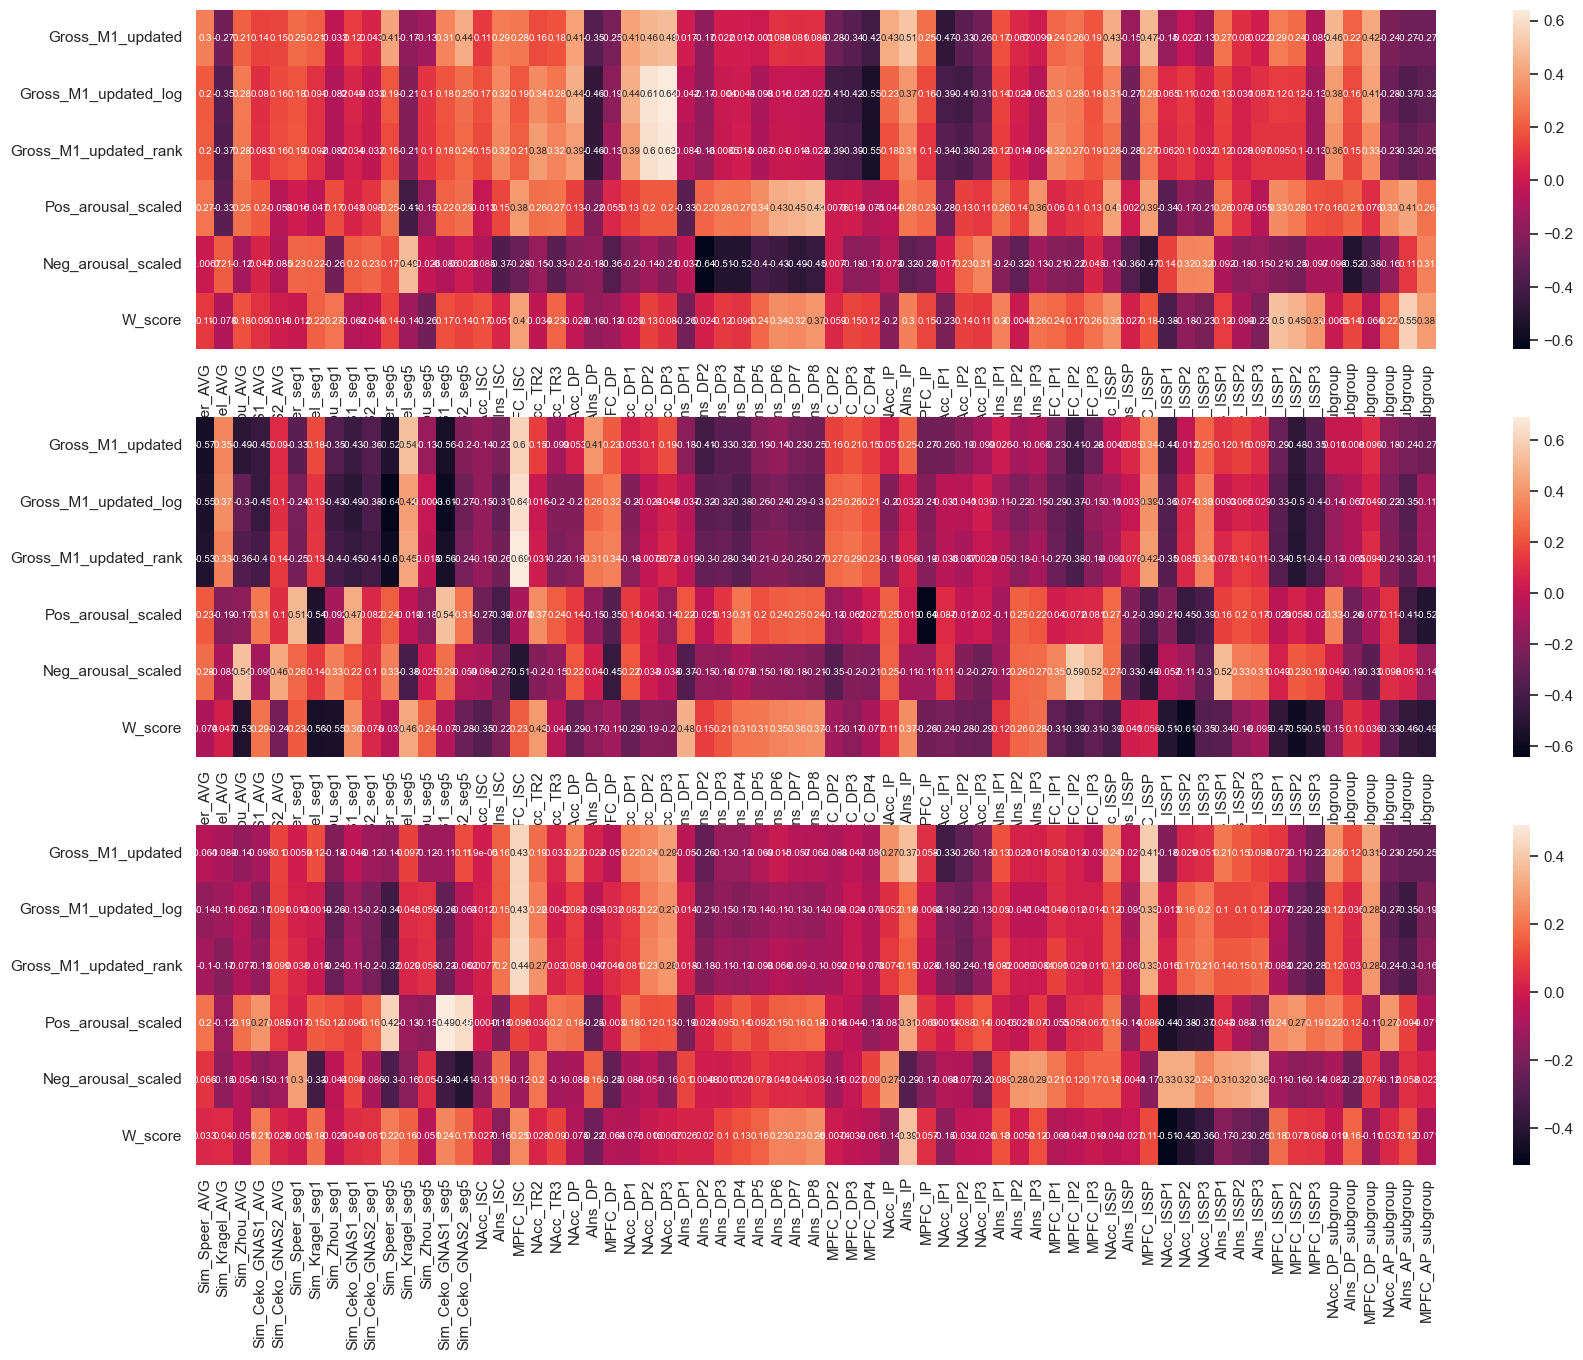

In [122]:


relevant_neuro_cols = ["Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank", 
                        #"DG_WK1", "DG_WK2", "DG_WK3","Gross_US_M1", "Gross_US_M1_rank", #"Gross_US_M1_log" ,
                       #"Gross_Total_US", #"GrossOverTheaters_M1", # These two were calculated with (cummulative gross)/(cummulative theaters)
                        #"GrossW1", "GrossW2", "GrossW3", "GrossM1", 
                        #"GrossTheatersM1", #"GT_AVG_W2", "GT_AVG_W3", "GT_AVG_M1",
                        #"GT_AVG_Total", "GT_AVG_Total_log", "GT_Total", 
                        "Pos_arousal_scaled", "Neg_arousal_scaled",  "W_score", #"IMDb_rating",
                        
                        "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
                        "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
                        "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",
                        'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
                        #"NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",
                        #"GrossTheatersW1", "GrossTheatersW2", "GrossTheatersW3", 
                         #'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle', 'AIns_middle', 'MPFC_middle',
                         #'NAcc_offset', 'AIns_offset', 'MPFC_offset',
                         #'NAcc_whole', 'AIns_whole', 'MPFC_whole', 
                         #'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
                        "NAcc_TR2", "NAcc_TR3", #"NAcc_TR5", "NAcc_TR6",
                         #"NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", 
                         #'NAcc_ind_peaks_pos', 'AIns_ind_peaks_pos', 'MPFC_ind_peaks_pos',
                         #'NAcc_ind_peaks_neg', 'AIns_ind_peaks_neg', 'MPFC_ind_peaks_neg', 
                         #'NAcc_trailer_peak_pos', 'AIns_trailer_peak_pos', 'MPFC_trailer_peak_pos', 
                         #"NAcc_trailer_peak_pos_yes", "AIns_trailer_peak_pos_yes", "MPFC_trailer_peak_pos_yes",
                         #"NAcc_trailer_peak_neg", "AIns_trailer_peak_neg", "MPFC_trailer_peak_neg", 
                         #"NAcc_ind_peaks_pos", "AIns_ind_peaks_pos", "MPFC_ind_peaks_pos",

                        "NAcc_DP", "AIns_DP", "MPFC_DP",
                        #"NAcc_AP", "AIns_AP", "MPFC_AP",
                        "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
                        #"NAcc_DPy1", "NAcc_DPy2", "NAcc_DPy3",
                        #"NAcc_AP1", "NAcc_AP2", "NAcc_AP3",
                        #"NAcc_APy1", "NAcc_APy2", "NAcc_APy3",
                        "AIns_DP1", "AIns_DP2", "AIns_DP3",
                        "AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8", 
                        "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
                        #"NAcc_DPy", "AIns_DPy", "MPFC_DPy",

                        "NAcc_IP", "AIns_IP", "MPFC_IP",
                        "NAcc_IP1", "NAcc_IP2", "NAcc_IP3",
                        "AIns_IP1", "AIns_IP2", "AIns_IP3",
                        "MPFC_IP1", "MPFC_IP2", "MPFC_IP3",

                        "NAcc_ISSP", "AIns_ISSP", "MPFC_ISSP",
                        "NAcc_ISSP1", "NAcc_ISSP2", "NAcc_ISSP3",
                        "AIns_ISSP1", "AIns_ISSP2", "AIns_ISSP3",
                        "MPFC_ISSP1", "MPFC_ISSP2", "MPFC_ISSP3",

                        #"NAcc_DS", "AIns_DS", "MPFC_DS",
                        #"NAcc_DSy", "AIns_DSy", "MPFC_DSy",
                        
                        # AIns_AP4,AIns_AP5,AIns_AP6,AIns_AP7,AIns_AP8,
                        #"NAcc_APy", "AIns_APy", "MPFC_APy",
                        #"NAcc_AP2", "AIns_AP2", "MPFC_AP2", 
                        #"NAcc_APy2", "AIns_APy2", "MPFC_APy2",

                        "NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
                        "NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",

                         #'AIns_avg_peak_pos4', 'AIns_avg_peak_pos5', 'AIns_avg_peak_pos6', 'AIns_avg_peak_pos7', 'AIns_avg_peak_pos8',
                         #'MPFC_dem_peak_pos2', 'MPFC_dem_peak_pos3', 'MPFC_dem_peak_pos4'
                         #"NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
                         #"AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
                         #"MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5"
                         ]
                         
print("Total trailers: ", aggregate_combined_df.shape[0])

aggregate_comedy_filtered_df = aggregate_combined_comedy_df[relevant_neuro_cols]
aggregate_comedy_filtered_df = aggregate_comedy_filtered_df.dropna()
aggregate_comedy_filtered_df = aggregate_comedy_filtered_df.corr()

aggregate_horror_filtered_df = aggregate_combined_horror_df[relevant_neuro_cols]
aggregate_horror_filtered_df = aggregate_horror_filtered_df.dropna()
aggregate_horror_filtered_df = aggregate_horror_filtered_df.corr()

aggregate_combined_filtered_df = aggregate_combined_df[relevant_neuro_cols]
aggregate_combined_filtered_df = aggregate_combined_filtered_df.dropna()
aggregate_combined_filtered_df = aggregate_combined_filtered_df.corr()

print("Total trailers: ", aggregate_combined_df.shape[0])

fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=False) 

sns.heatmap(aggregate_comedy_filtered_df.iloc[0:6, 6:], ax=axs[0], annot=True, annot_kws={'size': 7})
sns.heatmap(aggregate_horror_filtered_df.iloc[0:6, 6:], ax=axs[1], annot=True, annot_kws={'size': 7})
sns.heatmap(aggregate_combined_filtered_df.iloc[0:6, 6:], ax=axs[2], annot=True, annot_kws={'size': 7})

<Axes: >

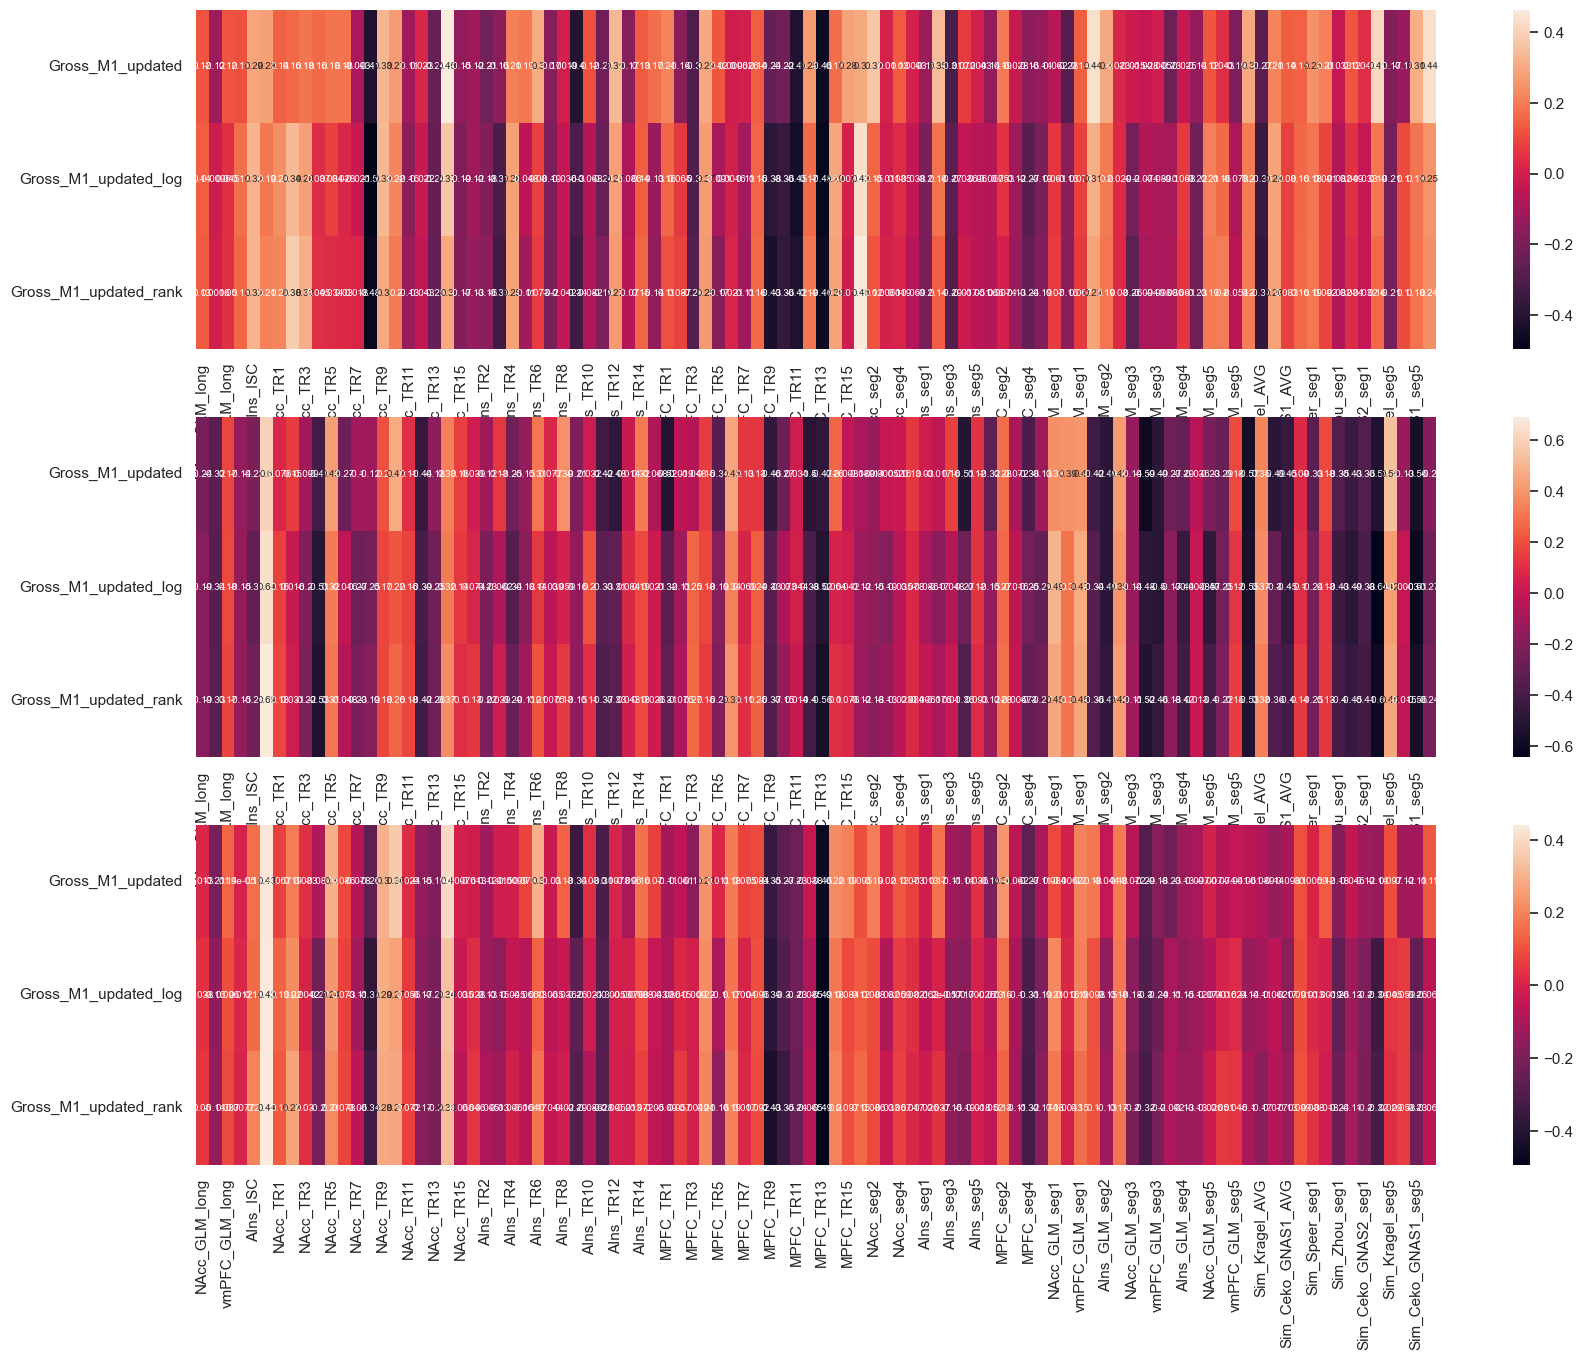

In [124]:


relevant_neuro_cols = ["Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank", 
                       "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", 
                       'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
                        
                        "NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15",
                        "AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15",
                        "MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15",

                         "NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
                         "AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
                         "MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5", "NAcc_GLM_seg1", "AIns_GLM_seg1", "vmPFC_GLM_seg1",
            "NAcc_GLM_seg2", "AIns_GLM_seg2", "vmPFC_GLM_seg2", "NAcc_GLM_seg3", "AIns_GLM_seg3", "vmPFC_GLM_seg3",
            "NAcc_GLM_seg4", "AIns_GLM_seg4", "vmPFC_GLM_seg4", "NAcc_GLM_seg5", "AIns_GLM_seg5", "vmPFC_GLM_seg5",
           "Sim_Speer_AVG", "Sim_Kragel_AVG", "Sim_Zhou_AVG", "Sim_Ceko_GNAS1_AVG", "Sim_Ceko_GNAS2_AVG",
            "Sim_Speer_seg1", "Sim_Kragel_seg1", "Sim_Zhou_seg1", "Sim_Ceko_GNAS1_seg1", "Sim_Ceko_GNAS2_seg1",
            "Sim_Speer_seg5", "Sim_Kragel_seg5", "Sim_Zhou_seg5", "Sim_Ceko_GNAS1_seg5", "Sim_Ceko_GNAS2_seg5",
                         ]
                         

aggregate_comedy_filtered_df = aggregate_combined_comedy_df[relevant_neuro_cols]
aggregate_comedy_filtered_df = aggregate_comedy_filtered_df.dropna()
aggregate_comedy_filtered_df = aggregate_comedy_filtered_df.corr()

aggregate_horror_filtered_df = aggregate_combined_horror_df[relevant_neuro_cols]
aggregate_horror_filtered_df = aggregate_horror_filtered_df.dropna()
aggregate_horror_filtered_df = aggregate_horror_filtered_df.corr()

aggregate_combined_filtered_df = aggregate_combined_df[relevant_neuro_cols]
aggregate_combined_filtered_df = aggregate_combined_filtered_df.dropna()
aggregate_combined_filtered_df = aggregate_combined_filtered_df.corr()

fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=False) 

sns.heatmap(aggregate_comedy_filtered_df.iloc[0:3, 3:], ax=axs[0], annot=True, annot_kws={'size': 7})
sns.heatmap(aggregate_horror_filtered_df.iloc[0:3, 3:], ax=axs[1], annot=True, annot_kws={'size': 7})
sns.heatmap(aggregate_combined_filtered_df.iloc[0:3, 3:], ax=axs[2], annot=True, annot_kws={'size': 7})

# Using vmPFC GLM for horror gets (r=0.55) with duration 10 sec.

<Axes: >

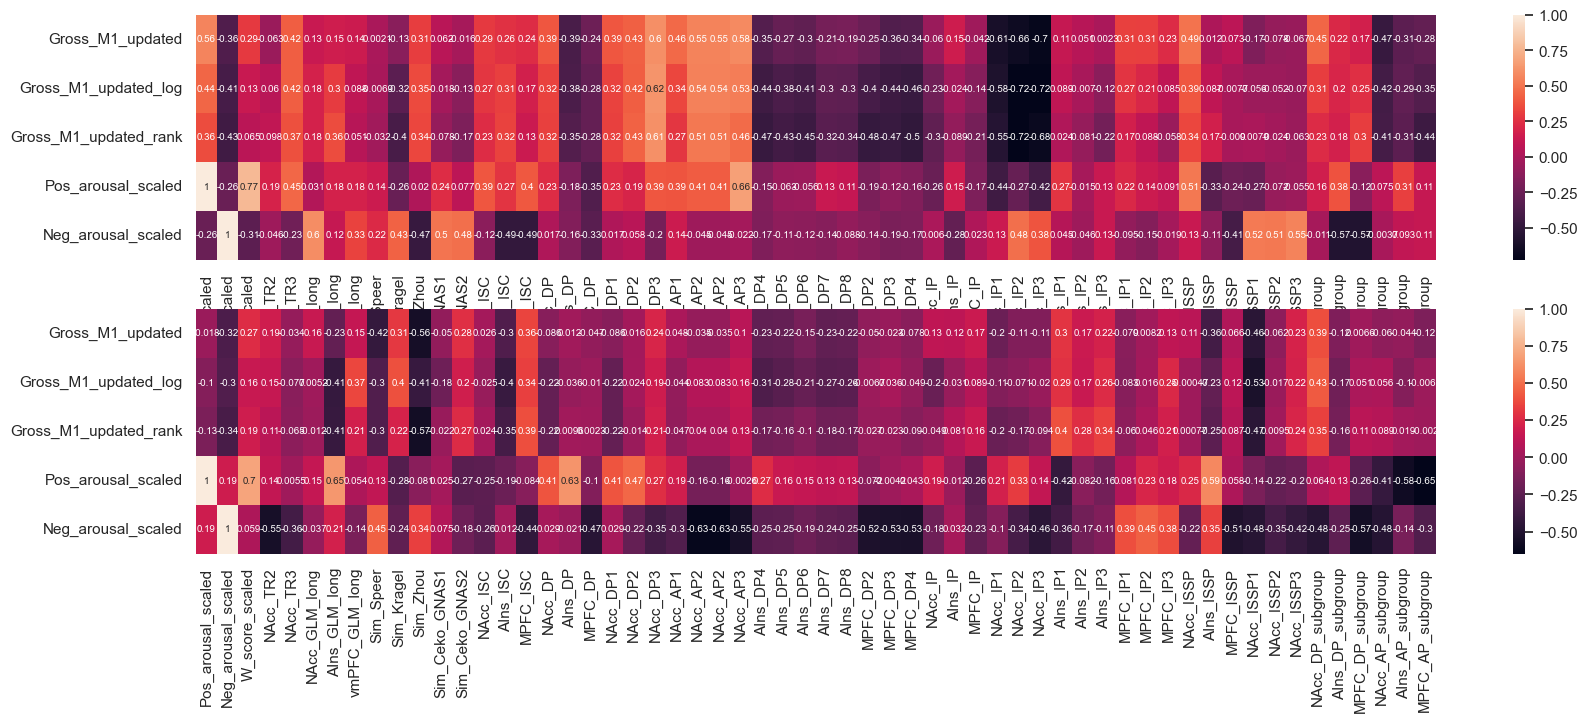

In [ ]:
# LC_aggregate_combined_df["GrossOverTheaters_M1"] = LC_aggregate_combined_df["Gross_US_M1"] / LC_aggregate_combined_df["Theaters_US_M1"]
# LH_aggregate_combined_df["GrossOverTheaters_M1"] = LH_aggregate_combined_df["Gross_US_M1"] / LH_aggregate_combined_df["Theaters_US_M1"]

# LC_aggregate_combined_df["GrossTheatersM1"] = (LC_aggregate_combined_df["DG_WK1"] / LC_aggregate_combined_df["NumT_WK1"]) + (LC_aggregate_combined_df["DG_WK2"] / LC_aggregate_combined_df["NumT_WK2"]) + (LC_aggregate_combined_df["DG_WK3"] / LC_aggregate_combined_df["NumT_WK3"]) + (LC_aggregate_combined_df["DG_WK4"] / LC_aggregate_combined_df["NumT_WK4"])
# LH_aggregate_combined_df["GrossTheatersM1"] = (LH_aggregate_combined_df["DG_WK1"] / LH_aggregate_combined_df["NumT_WK1"]) + (LH_aggregate_combined_df["DG_WK2"] / LH_aggregate_combined_df["NumT_WK2"]) + (LH_aggregate_combined_df["DG_WK3"] / LH_aggregate_combined_df["NumT_WK3"]) + (LH_aggregate_combined_df["DG_WK4"] / LH_aggregate_combined_df["NumT_WK4"])

# LC_aggregate_combined_df["GrossM1"] = (LC_aggregate_combined_df["DG_WK1"]) + (LC_aggregate_combined_df["DG_WK2"]) + (LC_aggregate_combined_df["DG_WK3"]) + (LC_aggregate_combined_df["DG_WK4"])
# LH_aggregate_combined_df["GrossM1"] = (LH_aggregate_combined_df["DG_WK1"]) + (LH_aggregate_combined_df["DG_WK2"]) + (LH_aggregate_combined_df["DG_WK3"]) + (LH_aggregate_combined_df["DG_WK4"])


# #LH_aggregate_combined_df.to_csv(root_path + "/AllSubs_NeuralActivation_Aggregate_LH.csv", index=True)

# LC_aggregate_combined_df["Gross_US_M1_rank"] = LC_aggregate_combined_df["Gross_US_M1"].rank()
# LH_aggregate_combined_df["Gross_US_M1_rank"] = LH_aggregate_combined_df["Gross_US_M1"].rank()

# LC_aggregate_combined_df["Gross_US_M1_log"] = np.log(LC_aggregate_combined_df["Gross_US_M1"])
# LH_aggregate_combined_df["Gross_US_M1_log"] = np.log(LH_aggregate_combined_df["Gross_US_M1"])



relevant_neuro_cols = [#"Gross_US_M1", "GrossOverTheaters_M1", "GrossM1", 
                        #"GrossTheatersM1", "Gross_US_M1_rank", "Gross_US_M1_log",
                        "Gross_M1_updated", "Gross_M1_updated_log", "Gross_M1_updated_rank", 
                        #"IMDb_rating", 
                        "Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled",
                        #'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle', 'AIns_middle', 'MPFC_middle',
                         #'NAcc_offset', 'AIns_offset', 'MPFC_offset',
                         #'NAcc_whole', 'AIns_whole', 'MPFC_whole', 
                         #'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC', 
                         "NAcc_TR2", "NAcc_TR3",
                         #'NAcc_ind_peaks_pos', 'AIns_ind_peaks_pos', 'MPFC_ind_peaks_pos',
                         #'NAcc_ind_peaks_neg', 'AIns_ind_peaks_neg', 'MPFC_ind_peaks_neg', 
                         #'NAcc_trailer_peak_pos', 'AIns_trailer_peak_pos', 'MPFC_trailer_peak_pos', 
                         #"NAcc_trailer_peak_pos_yes", "AIns_trailer_peak_pos_yes", "MPFC_trailer_peak_pos_yes",
                        
                        "NAcc_GLM_long", "AIns_GLM_long", "vmPFC_GLM_long", #"NAcc_GLM_short", "AIns_GLM_short", "vmPFC_GLM_short",
                        "Sim_Speer", "Sim_Kragel", "Sim_Zhou", "Sim_Ceko_GNAS1", "Sim_Ceko_GNAS2",
                        'NAcc_ISC', 'AIns_ISC', 'MPFC_ISC',
                        #"NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC", "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC",
                        "NAcc_DP", "AIns_DP", "MPFC_DP",
                        "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
                        "NAcc_AP1", "NAcc_AP2", "NAcc_AP3",
                        "AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8", 
                        "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
                        #"NAcc_DPy", "AIns_DPy", "MPFC_DPy",
                        #"NAcc_DS", "AIns_DS", "MPFC_DS",
                        #"NAcc_DSy", "AIns_DSy", "MPFC_DSy",
                        #"NAcc_AP", "AIns_AP", "MPFC_AP",
                        # AIns_AP4,AIns_AP5,AIns_AP6,AIns_AP7,AIns_AP8,
                        #"NAcc_APy", "AIns_APy", "MPFC_APy",
                        #"NAcc_AP2", "AIns_AP2", "MPFC_AP2", 
                        #"NAcc_APy2", "AIns_APy2", "MPFC_APy2",
                        "NAcc_IP", "AIns_IP", "MPFC_IP",
                        "NAcc_IP1", "NAcc_IP2", "NAcc_IP3",
                        "AIns_IP1", "AIns_IP2", "AIns_IP3",
                        "MPFC_IP1", "MPFC_IP2", "MPFC_IP3",

                        "NAcc_ISSP", "AIns_ISSP", "MPFC_ISSP",
                        "NAcc_ISSP1", "NAcc_ISSP2", "NAcc_ISSP3",

                        "NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
                        "NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",

                         #'AIns_dem_peak_pos8', 
                         #'AIns_avg_peak_pos4', 'AIns_avg_peak_pos5', 'AIns_avg_peak_pos6', 'AIns_avg_peak_pos7', 'AIns_avg_peak_pos8',
                         #'MPFC_dem_peak_pos2', 'MPFC_dem_peak_pos3', 'MPFC_dem_peak_pos4'
                         #"NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
                         #"AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
                         #"MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5"
                         ]

LC_aggregate_filtered_df = LC_aggregate_combined_df[relevant_neuro_cols]
LC_aggregate_filtered_df = LC_aggregate_filtered_df.dropna()
LC_aggregate_filtered_df = LC_aggregate_filtered_df.corr()

LH_aggregate_filtered_df = LH_aggregate_combined_df[relevant_neuro_cols]
LH_aggregate_filtered_df = LH_aggregate_filtered_df.dropna()
LH_aggregate_filtered_df = LH_aggregate_filtered_df.corr()

fig, axs = plt.subplots(2, 1, figsize=(20, 7), sharex=False)

sns.heatmap(LC_aggregate_filtered_df.iloc[0:5, 3:], ax=axs[0], annot=True, annot_kws={'size': 7})
sns.heatmap(LH_aggregate_filtered_df.iloc[0:5, 3:], ax=axs[1], annot=True, annot_kws={'size': 7})


In [ ]:


# Separate df by run. 
all_subs_events_comedy_r1 = aggregate_combined_comedy_df[aggregate_combined_comedy_df["Trailer"].isin(r1_keys_sorted)]  

all_subs_events_comedy_r2 = aggregate_combined_comedy_df[aggregate_combined_comedy_df["Trailer"].isin(r2_keys_sorted)]

TR3_M1_log_corr = pearsonr(aggregate_combined_comedy_df["NAcc_TR2"], aggregate_combined_comedy_df["Gross_M1_updated_log"])

TR3_M1_log_r1_corr = pearsonr(all_subs_events_comedy_r1["NAcc_TR2"], all_subs_events_comedy_r1["Gross_M1_updated_log"])

#TR3_M1_log_r2_corr = pearsonr(all_subs_events_comedy_r2["NAcc_TR2"], all_subs_events_comedy_r2["Gross_M1_updated_log"])

print("The correlation between NAcc_TR2 and M1_log for all runs is: ", TR3_M1_log_corr)

print("The correlation between NAcc_TR2 and M1_log for run 1 is: ", TR3_M1_log_r1_corr)

#print("The correlation between NAcc_TR2 and M1_log for run 2 is: ", TR3_M1_log_r2_corr)

NAccDP_M1_log_corr = pearsonr(aggregate_combined_comedy_df["NAcc_DP3"], aggregate_combined_comedy_df["Gross_M1_updated_log"])

NAccDP_M1_log_r1_corr = pearsonr(all_subs_events_comedy_r1["NAcc_DP3"], all_subs_events_comedy_r1["Gross_M1_updated_log"])

NAccDP_M1_log_r2_corr = pearsonr(all_subs_events_comedy_r2["NAcc_DP3"], all_subs_events_comedy_r2["Gross_M1_updated_log"])

print("\nThe correlation between NAcc_DP2 and M1_log for all runs is: ", NAccDP_M1_log_corr)

print("The correlation between NAcc_DP2 and M1_log for run 1 is: ", NAccDP_M1_log_r1_corr)

print("The correlation between NAcc_DP2 and M1_log for run 2 is: ", NAccDP_M1_log_r2_corr)






The correlation between NAcc_TR2 and M1_log for all runs is:  PearsonRResult(statistic=0.3365562192013082, pvalue=0.20245013148203844)
The correlation between NAcc_TR2 and M1_log for run 1 is:  PearsonRResult(statistic=0.8982572816258473, pvalue=0.0024361672146138305)

The correlation between NAcc_DP2 and M1_log for all runs is:  PearsonRResult(statistic=0.6411204948619291, pvalue=0.007441268144482207)
The correlation between NAcc_DP2 and M1_log for run 1 is:  PearsonRResult(statistic=0.65758081611739, pvalue=0.07636063021552188)
The correlation between NAcc_DP2 and M1_log for run 2 is:  PearsonRResult(statistic=0.5821603176889967, pvalue=0.12999961664297796)


In [ ]:
"""
# Filter data and append aggregate metrics.
Aggregate_comedy_df <- filter(Individual_comedy_df,
                       ("NAcc_onset_z" < filtering_threshold) | ("NAcc_onset_z" > -filtering_threshold)  |
                       ("AIns_onset_z" < filtering_threshold) | ("AIns_onset_z" > -filtering_threshold)  |
                       ("MPFC_onset_z" < filtering_threshold) | ("MPFC_onset_z" > -filtering_threshold)  |
                       ("NAcc_middle_z" < filtering_threshold) | ("NAcc_middle_z" > -filtering_threshold) |
                       ("AIns_middle_z" < filtering_threshold) | ("AIns_middle_z" > -filtering_threshold) |
                       ("MPFC_middle_z" < filtering_threshold) | ("MPFC_middle_z" > -filtering_threshold) |
                       ("NAcc_offset_z" < filtering_threshold) | ("NAcc_offset_z" > -filtering_threshold) |
                       ("AIns_offset_z" < filtering_threshold) | ("AIns_offset_z" > -filtering_threshold) |
                       ("MPFC_offset_z" < filtering_threshold) | ("MPFC_offset_z" > -filtering_threshold) |
                       ("NAcc_ind_peaks_pos_z" < filtering_threshold) | ("NAcc_ind_peaks_pos_z" > -filtering_threshold) |
                       ("AIns_ind_peaks_pos_z" < filtering_threshold) | ("AIns_ind_peaks_pos_z" > -filtering_threshold) |
                       ("MPFC_ind_peaks_pos_z" < filtering_threshold) | ("MPFC_ind_peaks_pos_z" > -filtering_threshold) |
                       ("NAcc_dem_peak_pos_z" < filtering_threshold) | ("NAcc_dem_peak_pos_z" > -filtering_threshold) |
                       ("AIns_dem_peak_pos_z" < filtering_threshold) | ("AIns_dem_peak_pos_z" > -filtering_threshold) |
                       ("MPFC_dem_peak_pos_z" < filtering_threshold) | ("MPFC_dem_peak_pos_z" > -filtering_threshold) |
                       ("NAcc_dem_peak_pos_yes_z" < filtering_threshold) | ("NAcc_dem_peak_pos_yes_z" > -filtering_threshold) |
                       ("AIns_dem_peak_pos_yes_z" < filtering_threshold) | ("AIns_dem_peak_pos_yes_z" > -filtering_threshold) |
                       ("MPFC_dem_peak_pos_yes_z" < filtering_threshold) | ("MPFC_dem_peak_pos_yes_z" > -filtering_threshold) |
                       ("NAcc_avg_peak_pos_z" < filtering_threshold) | ("NAcc_avg_peak_pos_z" > -filtering_threshold) |
                       ("AIns_avg_peak_pos_z" < filtering_threshold) | ("AIns_avg_peak_pos_z" > -filtering_threshold) |
                       ("MPFC_avg_peak_pos_z" < filtering_threshold) | ("MPFC_avg_peak_pos_z" > -filtering_threshold) |
                       ("NAcc_avg_peak_yes_pos" < filtering_threshold) | ("NAcc_avg_peak_yes_pos" > -filtering_threshold) |
                       ("AIns_avg_peak_yes_pos" < filtering_threshold) | ("AIns_avg_peak_yes_pos" > -filtering_threshold) |
                       ("MPFC_avg_peak_yes_pos" < filtering_threshold) | ("MPFC_avg_peak_yes_pos" > -filtering_threshold)) %>% 
                       group_by(Trailer) %>%
                       summarise_if(is.numeric, mean, na.rm = TRUE) #%>%
        
Aggregate_comedy_df <- merge(x = Aggregate_comedy_df, y = Aggregate_metrics_comedy_df, by = "Trailer")


relevant_cols = ["Trailer", 'Pos_arousal_scaled', 'Neg_arousal_scaled', 'W_score_scaled',
         'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle', 'AIns_middle', 'MPFC_middle',
         'NAcc_offset', 'AIns_offset', 'MPFC_offset', "NAcc_ISC", "AIns_ISC", "MPFC_ISC",
         "NAcc_LC_ISC", "AIns_LC_ISC", "MPFC_LC_ISC", "NAcc_DC_ISC", "AIns_DC_ISC", "MPFC_DC_ISC",
         "NAcc_dem_peak_pos", "AIns_dem_peak_pos", "MPFC_dem_peak_pos",
         #"NAcc_dem_peak_neg", "AIns_dem_peak_neg", "MPFC_dem_peak_neg", 
         "NAcc_dem_peak_pos_yes" , "AIns_dem_peak_pos_yes", "MPFC_dem_peak_pos_yes", 
         "NAcc_dem_peak_pos_no" , "AIns_dem_peak_pos_no", "MPFC_dem_peak_pos_no", 
         'AIns_dem_peak_pos4', 'AIns_dem_peak_pos5', 'AIns_dem_peak_pos6', 'AIns_dem_peak_pos7',
         'AIns_dem_peak_pos8']

NAcc_TRs_keys = ['NAcc_TR1', 'NAcc_TR2', 'NAcc_TR3', 'NAcc_TR4', 'NAcc_TR5', 
                'NAcc_TR6', 'NAcc_TR7', 'NAcc_TR8', 'NAcc_TR9', 'NAcc_TR10',
                'NAcc_TR11', 'NAcc_TR12', 'NAcc_TR13', 'NAcc_TR14', 'NAcc_TR15']

AIns_TRs_keys = ['AIns_TR1', 'AIns_TR2', 'AIns_TR3', 'AIns_TR4', 'AIns_TR5',
                'AIns_TR6', 'AIns_TR7', 'AIns_TR8', 'AIns_TR9', 'AIns_TR10',
                'AIns_TR11', 'AIns_TR12', 'AIns_TR13', 'AIns_TR14', 'AIns_TR15']

MPFC_TRs_keys = ['MPFC_TR1', 'MPFC_TR2', 'MPFC_TR3', 'MPFC_TR4', 'MPFC_TR5',
                'MPFC_TR6', 'MPFC_TR7', 'MPFC_TR8', 'MPFC_TR9', 'MPFC_TR10',
                'MPFC_TR11', 'MPFC_TR12', 'MPFC_TR13', 'MPFC_TR14', 'MPFC_TR15']

# LC_df = LC_df[relevant_cols + NAcc_TRs_keys + AIns_TRs_keys + MPFC_TRs_keys]
# Like_comedy_aggregate_df = LC_df.groupby("Trailer", as_index=False, dropna=False).mean()
# Like_comedy_aggregate_df.reset_index(inplace=True)
# Like_comedy_aggregate_df["Type"] = "comedy"
"""

'\n# Filter data and append aggregate metrics.\nAggregate_comedy_df <- filter(Individual_comedy_df,\n                       ("NAcc_onset_z" < filtering_threshold) | ("NAcc_onset_z" > -filtering_threshold)  |\n                       ("AIns_onset_z" < filtering_threshold) | ("AIns_onset_z" > -filtering_threshold)  |\n                       ("MPFC_onset_z" < filtering_threshold) | ("MPFC_onset_z" > -filtering_threshold)  |\n                       ("NAcc_middle_z" < filtering_threshold) | ("NAcc_middle_z" > -filtering_threshold) |\n                       ("AIns_middle_z" < filtering_threshold) | ("AIns_middle_z" > -filtering_threshold) |\n                       ("MPFC_middle_z" < filtering_threshold) | ("MPFC_middle_z" > -filtering_threshold) |\n                       ("NAcc_offset_z" < filtering_threshold) | ("NAcc_offset_z" > -filtering_threshold) |\n                       ("AIns_offset_z" < filtering_threshold) | ("AIns_offset_z" > -filtering_threshold) |\n                       ("MPFC_